# True FOM

In [1]:
# load in thekla data

In [13]:

# import stuff
import sys,os,os.path
import csv
import traceback
#sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/scratch/halmazan/NEXT/IC_alter-blob-centre/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/scratch/halmazan/NEXT/testing/notebooks/FOM_creator/")
os.environ['ICTDIR']='/scratch/halmazan/NEXT/IC_alter-blob-centre/'

from invisible_cities.core.core_functions   import shift_to_bin_centers
from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer

import FOM_functions as FOM_func
import functions_HE as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd





import scipy.special as special
from scipy.stats import norm
from scipy.stats import skewnorm, crystalball
from scipy.optimize import curve_fit
from tqdm import tqdm

from scipy.integrate import quad

import iminuit
from iminuit import Minuit
import probfit
from concurrent.futures import ProcessPoolExecutor

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

from typing          import Optional
from typing          import Union
from typing          import Callable

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
from pathlib import Path

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
#from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm



## If you're loading in a topology city

In [14]:
CITY = 'TOPOLOGY'
FOM_TS = ['456018']

TIMESTAMP = FOM_TS
RUN_NUMBER = '250925'
RUN_NUMBER = [int(x) for x in RUN_NUMBER.split(',')]
# make directory
pre_dir = '/scratch/halmazan/NEXT/PROCESSING/FOM/data/'
folder_name = f'{pre_dir}/{FOM_TS}'
folder_s = Path(f'{folder_name}')
folder_s.mkdir(parents=True, exist_ok=True)
# load
hdst_local = []
for RN, TS in zip(RUN_NUMBER, TIMESTAMP):
    print(f'R{RN}: {TS}', flush = True)
    n100_dir = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data_MC/{RN}/{TS}/'
    hdst_local.append(pd.read_hdf(f'{n100_dir}cut_hdst.h5'))
    print(f'Loaded!', flush = True)
tdst = pd.concat(hdst_local)
 

R250925: 456018
Loaded!


## If you're loading in an isaura output

In [15]:
CITY = 'ISAURA'
FOM_TS = ['456018']
#FOM_TS = ['201025']
TIMESTAMP = FOM_TS
RUN_NUMBER = '250925'
RUN_NUMBER = [int(x) for x in RUN_NUMBER.split(',')]
# make directory
pre_dir = '/scratch/halmazan/NEXT/PROCESSING/MC_isaura/data'
folder_name = f'{pre_dir}/{RUN_NUMBER[0]}/{FOM_TS[0]}/'
folder_s = Path(f'{folder_name}')

tdst = []
for LDC in tqdm(range(1,8)):
    files = list(Path(f'{folder_name}/ldc{LDC}/').rglob('*.h5'))
    tdst.append(load_dsts(files, 'Tracking', 'Tracks'))

tdst = pd.concat(tdst)
display(tdst)


100%|███████████████████████████████████████████████████████████████████████████████████████| 7/7 [07:29<00:00, 64.15s/it]


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,222660000,0,1.552767,504.333795,128,1084,1,357.254547,97.148201,531.057007,...,532.180603,378.873578,322.233771,621.710715,0.298631,0.055189,0.000000,5.842872,5.968775,5.701891
1,222660001,0,1.924014,480.071152,138,1244,3,-112.123512,-469.716309,363.641571,...,498.042297,58.280767,-351.784310,438.940687,0.451901,0.094578,0.000000,5.922132,5.748130,5.933557
2,222660001,1,0.033180,0.000000,1,35,3,-64.658493,-422.455231,483.320007,...,483.439892,-64.469086,-421.806196,483.439892,0.033180,0.033180,0.033180,5.922132,5.748130,5.933557
3,222660001,2,0.018600,0.000000,1,44,3,-61.487862,-445.174622,485.063354,...,485.083319,-61.426574,-445.150436,485.083319,0.018600,0.018600,0.018600,5.922132,5.748130,5.933557
4,222660002,0,0.963678,245.503045,71,515,5,232.457321,28.430504,1141.468872,...,1171.642402,232.457321,45.173069,1209.732300,0.471378,0.074764,0.000000,5.926971,5.935205,5.862730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455252,136512108,4,0.029452,0.000000,1,50,5,327.738281,25.569799,863.280212,...,863.478596,327.874330,25.659691,863.478596,0.029452,0.029452,0.029452,5.974298,5.991688,5.959115
455253,136512109,0,1.744305,496.071843,140,1143,4,286.391663,3.631064,563.121582,...,717.546008,369.030390,268.053197,570.883378,0.486678,0.085896,0.000000,5.830550,5.917230,5.877918
455254,136512109,1,0.033851,5.830550,2,64,4,402.967163,86.725632,575.200195,...,575.214856,403.417246,86.913209,575.427391,0.033851,0.033851,0.033851,5.830550,5.917230,5.877918
455255,136512109,2,0.029781,0.000000,1,56,4,427.911804,76.602699,589.323608,...,589.926210,428.218825,76.841625,589.926210,0.029781,0.029781,0.029781,5.830550,5.917230,5.877918


In [23]:
display(tdst)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,222660000,0,1.552767,504.333795,128,1084,1,357.254547,97.148201,531.057007,...,532.180603,378.873578,322.233771,621.710715,0.298631,0.055189,0.000000,5.842872,5.968775,5.701891
1,222660001,0,1.924014,480.071152,138,1244,3,-112.123512,-469.716309,363.641571,...,498.042297,58.280767,-351.784310,438.940687,0.451901,0.094578,0.000000,5.922132,5.748130,5.933557
2,222660001,1,0.033180,0.000000,1,35,3,-64.658493,-422.455231,483.320007,...,483.439892,-64.469086,-421.806196,483.439892,0.033180,0.033180,0.033180,5.922132,5.748130,5.933557
3,222660001,2,0.018600,0.000000,1,44,3,-61.487862,-445.174622,485.063354,...,485.083319,-61.426574,-445.150436,485.083319,0.018600,0.018600,0.018600,5.922132,5.748130,5.933557
4,222660002,0,0.963678,245.503045,71,515,5,232.457321,28.430504,1141.468872,...,1171.642402,232.457321,45.173069,1209.732300,0.471378,0.074764,0.000000,5.926971,5.935205,5.862730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455252,136512108,4,0.029452,0.000000,1,50,5,327.738281,25.569799,863.280212,...,863.478596,327.874330,25.659691,863.478596,0.029452,0.029452,0.029452,5.974298,5.991688,5.959115
455253,136512109,0,1.744305,496.071843,140,1143,4,286.391663,3.631064,563.121582,...,717.546008,369.030390,268.053197,570.883378,0.486678,0.085896,0.000000,5.830550,5.917230,5.877918
455254,136512109,1,0.033851,5.830550,2,64,4,402.967163,86.725632,575.200195,...,575.214856,403.417246,86.913209,575.427391,0.033851,0.033851,0.033851,5.830550,5.917230,5.877918
455255,136512109,2,0.029781,0.000000,1,56,4,427.911804,76.602699,589.323608,...,589.926210,428.218825,76.841625,589.926210,0.029781,0.029781,0.029781,5.830550,5.917230,5.877918


In [24]:
# load in the numpy array
signal_labels = np.load('MC_truth_FOM/positrons_250925.npy')
display(signal_labels)

array([226716009, 226716013, 226716015, ..., 131328085, 131328094,
       131328098])

In [25]:
# separate out signal and background
signal_df = tdst[tdst.event.isin(signal_labels)]
bckgnd_df = tdst[~tdst.event.isin(signal_labels)]

In [26]:
# check
print(f'Do the number of events make sense?')
print(f'{signal_df.event.nunique() + bckgnd_df.event.nunique() == tdst.event.nunique()}')

Do the number of events make sense?
True


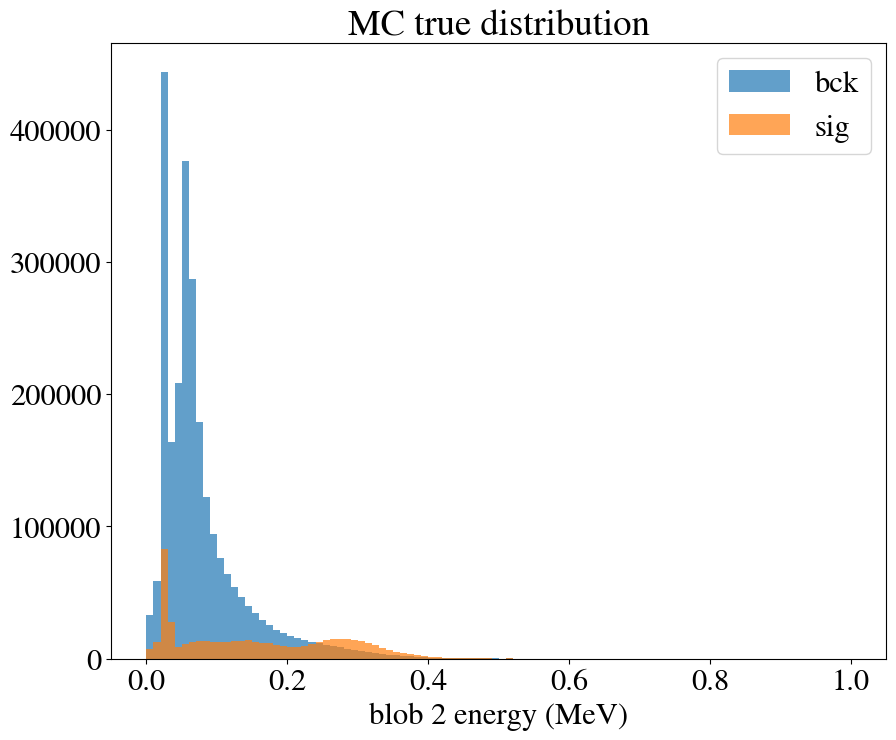

In [27]:
# signal vs background blob 2 distro
plt.hist(bckgnd_df.eblob2.values, label = 'bck', range = [0, 1], bins = 100, alpha = 0.7)
plt.hist(signal_df.eblob2.values, label = 'sig', range = [0, 1], bins = 100, alpha = 0.7)
plt.title('MC true distribution')
plt.xlabel('blob 2 energy (MeV)')
plt.legend()
plt.show()

## If its isaura, apply cuts and replot

Cutting events around fiducial volume related to:
Z range between 20 and 1195
Radius range < 450
Fiducial track cut
Relative Cut efficiency:
Efficiency: 47.93 %
Absolute Cut efficiency:
Efficiency: 47.93 %
One track cut
Relative Cut efficiency:
Efficiency: 50.90 %
Absolute Cut efficiency:
Efficiency: 43.77 %

Blob overlap cut
Relative Cut efficiency:
Efficiency: 99.99 %
Absolute Cut efficiency:
Efficiency: 44.66 %
Energy cut
Relative Cut efficiency:
Efficiency: 40.03 %
Absolute Cut efficiency:
Efficiency: 34.70 %


,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,1393227,100.000000
1,Fiducial Cuts,47.934184,667832,47.934184
2,One track cut,50.900676,339931,43.768532
3,Blob overlap cuts,99.988821,339893,44.662930
4,Energy cuts,40.034364,136074,34.703390


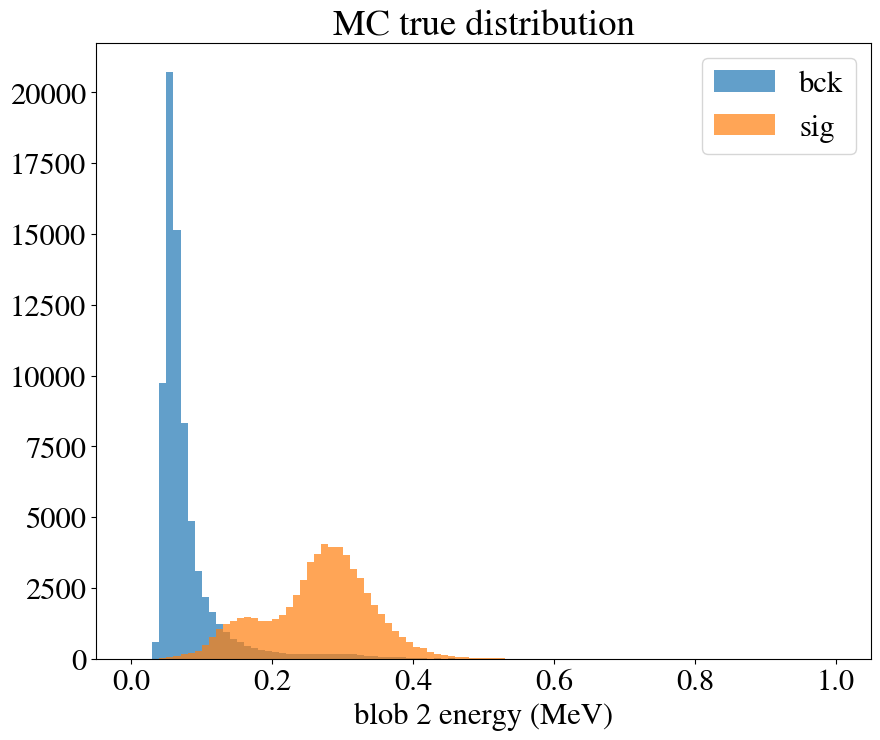

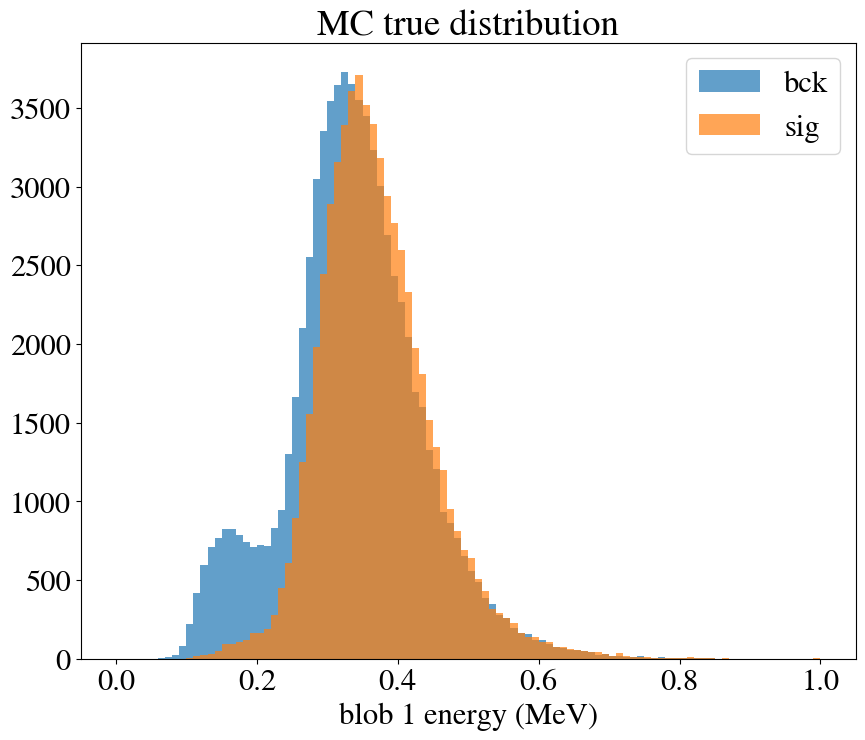

In [37]:
if CITY == 'ISAURA':
    #######################################################################################
    #########################   CUT PARAMETERS   #####################################
    #######################################################################################
    low_z = 20
    upp_z  = 1195
    r_lim = 450
    low_e = 1.4
    upp_e = 1.8

    cut_hdst, efficiencies = func.apply_cuts(tdst, 
                                             lower_z = low_z, 
                                             upper_z = upp_z, 
                                             r_lim   = r_lim, 
                                             lower_e = low_e, 
                                             upper_e = upp_e)

    display(efficiencies)

    # separate out signal and background
    signal_df = cut_hdst[cut_hdst.event.isin(signal_labels)]
    bckgnd_df = cut_hdst[~cut_hdst.event.isin(signal_labels)]


    # signal vs background blob 2 distro
    plt.hist(bckgnd_df.eblob2.values, label = 'bck', range = [0, 1], bins = 100, alpha = 0.7)
    plt.hist(signal_df.eblob2.values, label = 'sig', range = [0, 1], bins = 100, alpha = 0.7)
    plt.title('MC true distribution')
    plt.xlabel('blob 2 energy (MeV)')
    plt.legend()
    plt.show()


        # signal vs background blob 2 distro
    plt.hist(bckgnd_df.eblob1.values, label = 'bck', range = [0, 1], bins = 100, alpha = 0.7)
    plt.hist(signal_df.eblob1.values, label = 'sig', range = [0, 1], bins = 100, alpha = 0.7)
    plt.title('MC true distribution')
    plt.xlabel('blob 1 energy (MeV)')
    plt.legend()
    plt.show()

In [ ]:
np.save('MC_truth_FOM/cut_hdst.npy', cut_hdst.event.unique())
signal_df.to_hdf('MC_truth_FOM/signal_df.h5', 'signal_dst')
bckgnd_df.to_hdf('MC_truth_FOM/bckgnd_df.h5', 'signal_dst')

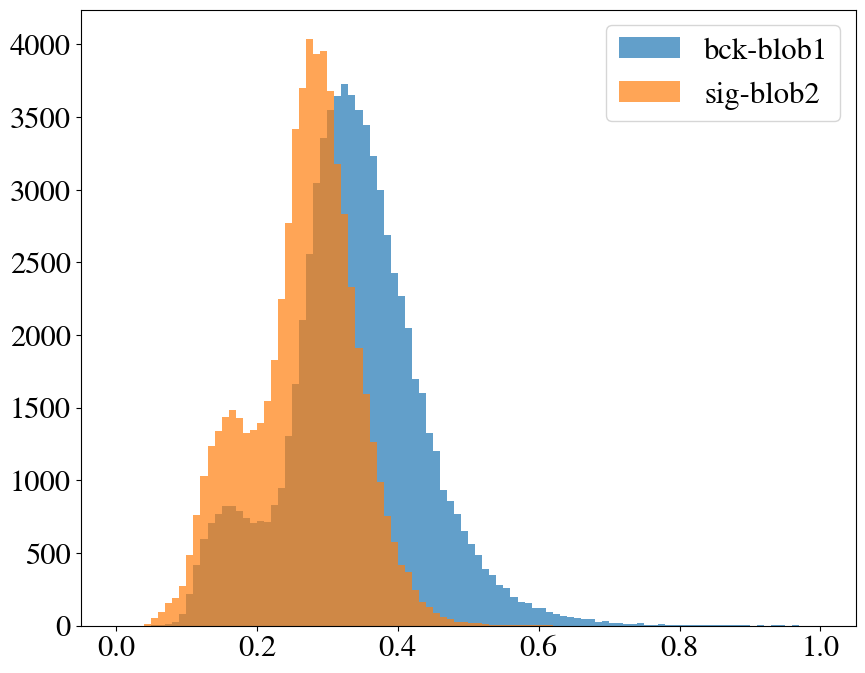

In [39]:
# signal vs background blob 2 distro
plt.hist(bckgnd_df.eblob1.values, label = 'bck-blob1', range = [0, 1], bins = 100, alpha = 0.7)    # signal vs background blob 2 distro

plt.hist(signal_df.eblob2.values, label = 'sig-blob2', range = [0, 1], bins = 100, alpha = 0.7)
plt.legend()
plt.show()

### quick side-quest. Select these events with low blob 2 energy in the signal region

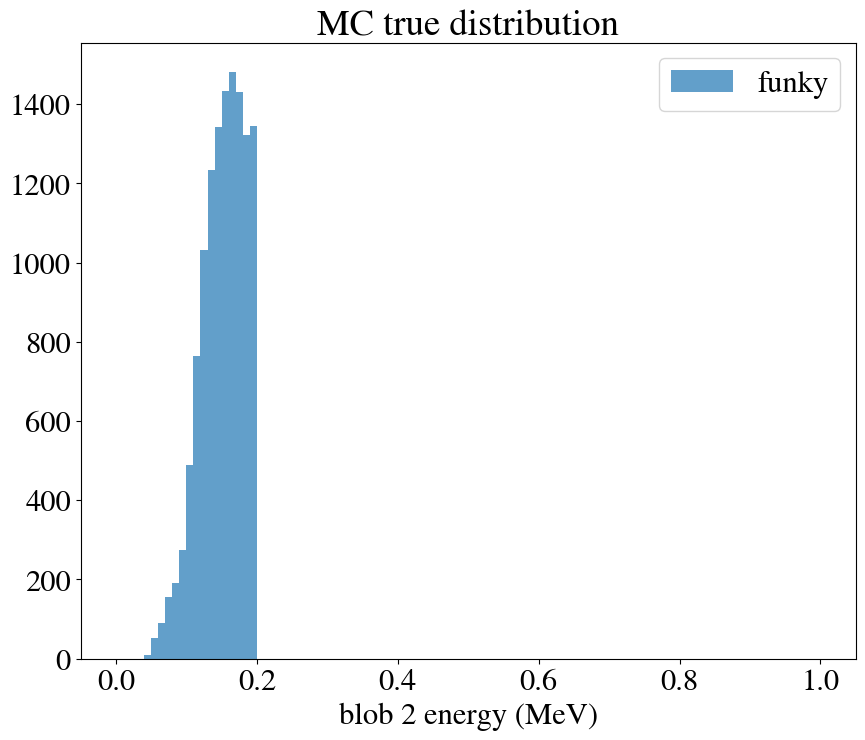

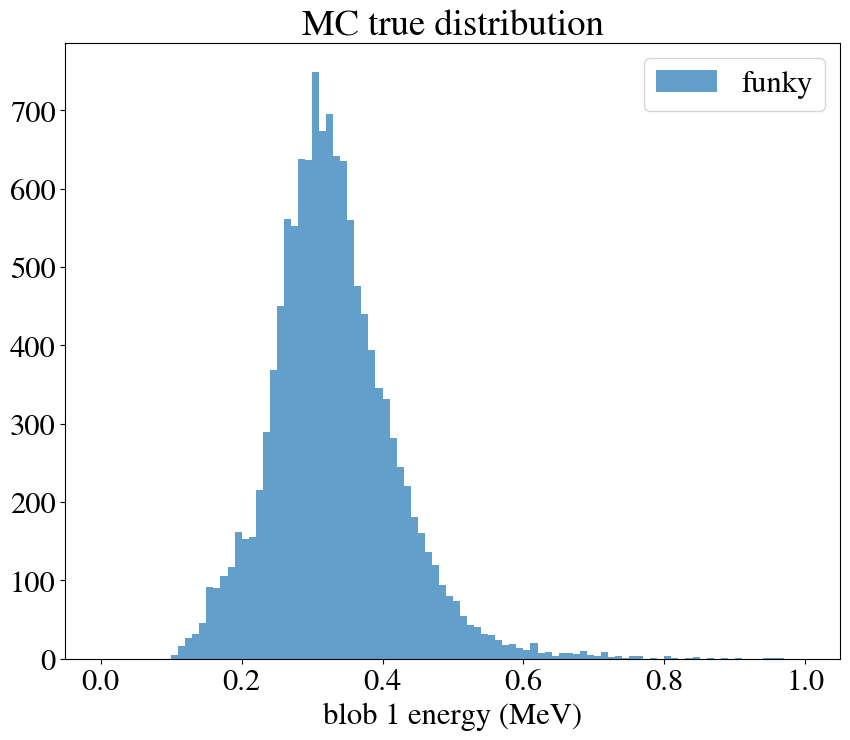

In [30]:
funky_blob2s = signal_df[signal_df['eblob2'] < 0.2]


# signal vs background blob 2 distro
plt.hist(funky_blob2s.eblob2.values, label = 'funky', range = [0, 1], bins = 100, alpha = 0.7)

plt.title('MC true distribution')
plt.xlabel('blob 2 energy (MeV)')
plt.legend()
plt.show()

# signal vs background blob 2 distro
plt.hist(funky_blob2s.eblob1.values, label = 'funky', range = [0, 1], bins = 100, alpha = 0.7)
plt.title('MC true distribution')
plt.xlabel('blob 1 energy (MeV)')
plt.legend()
plt.show()

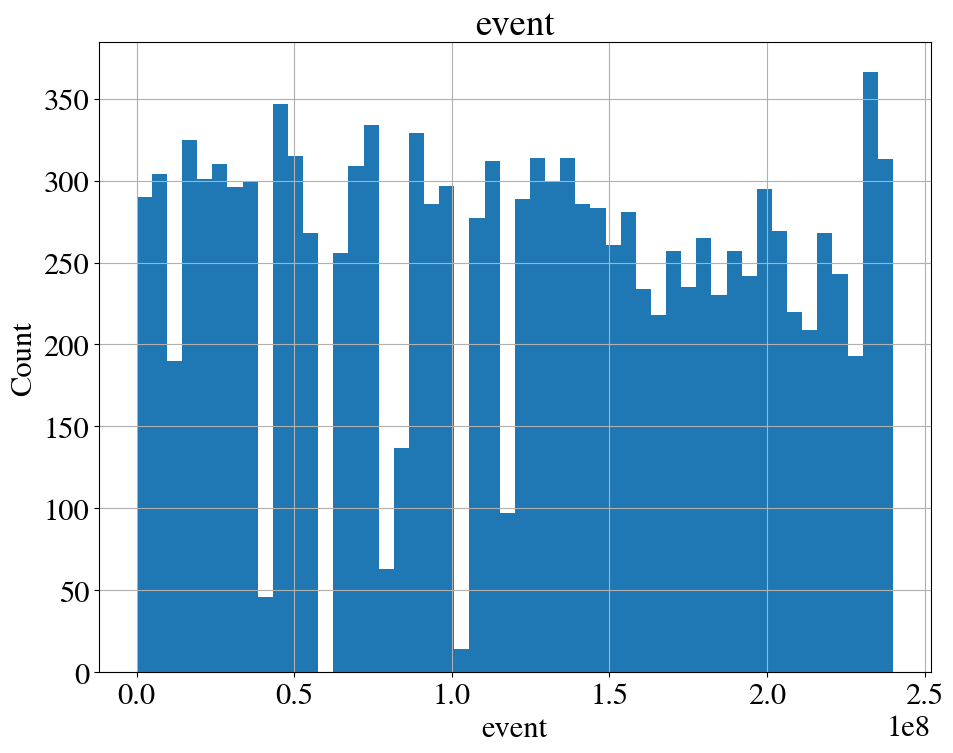

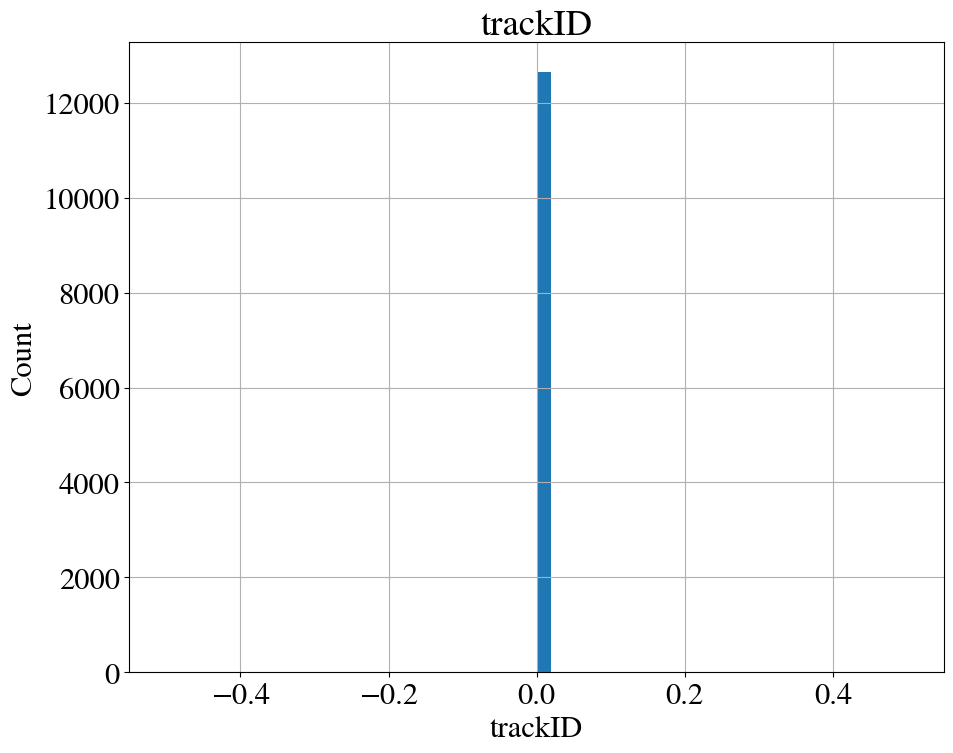

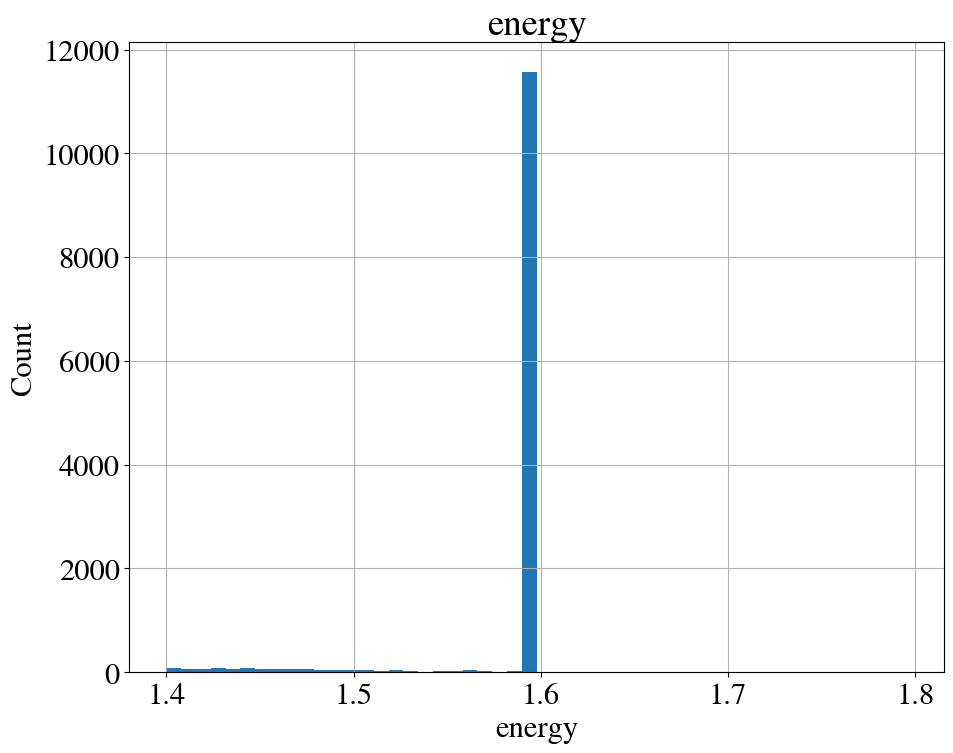

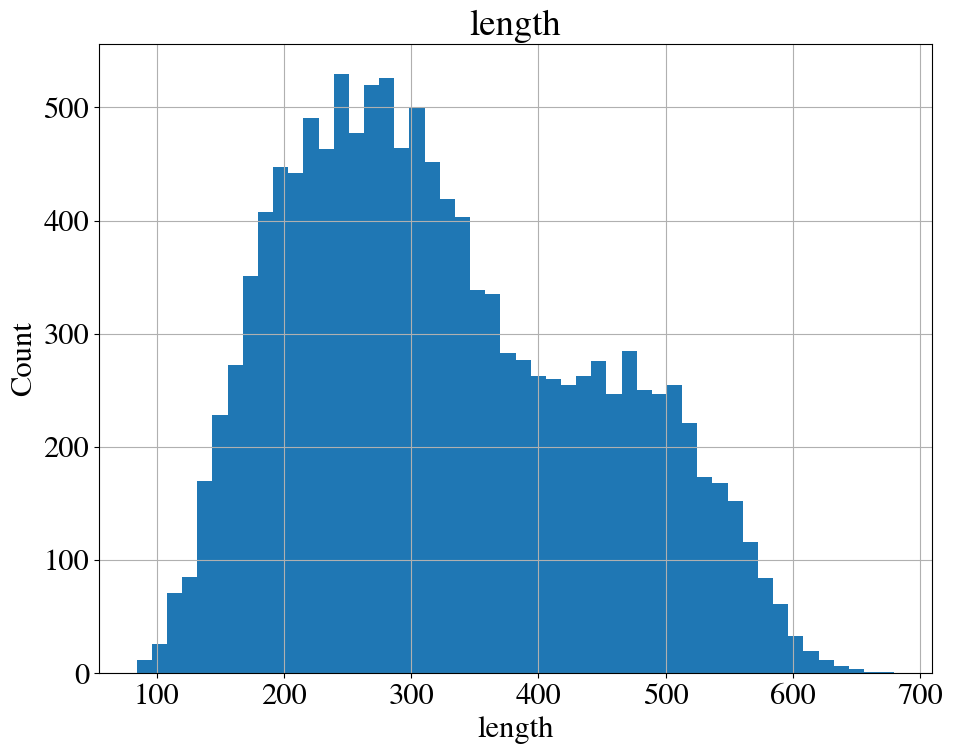

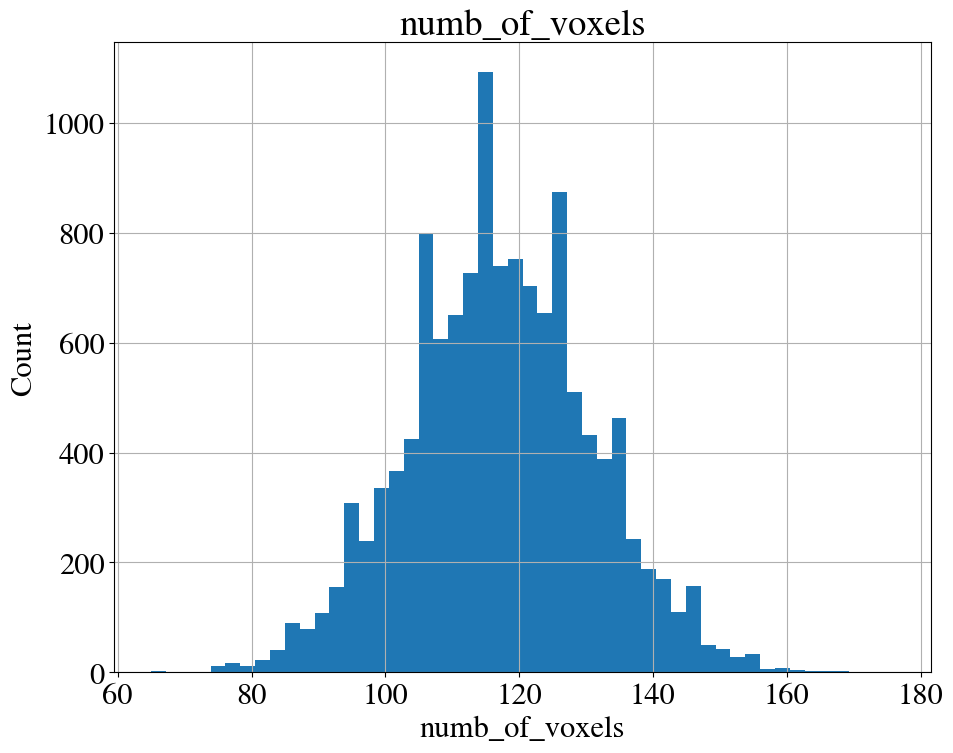

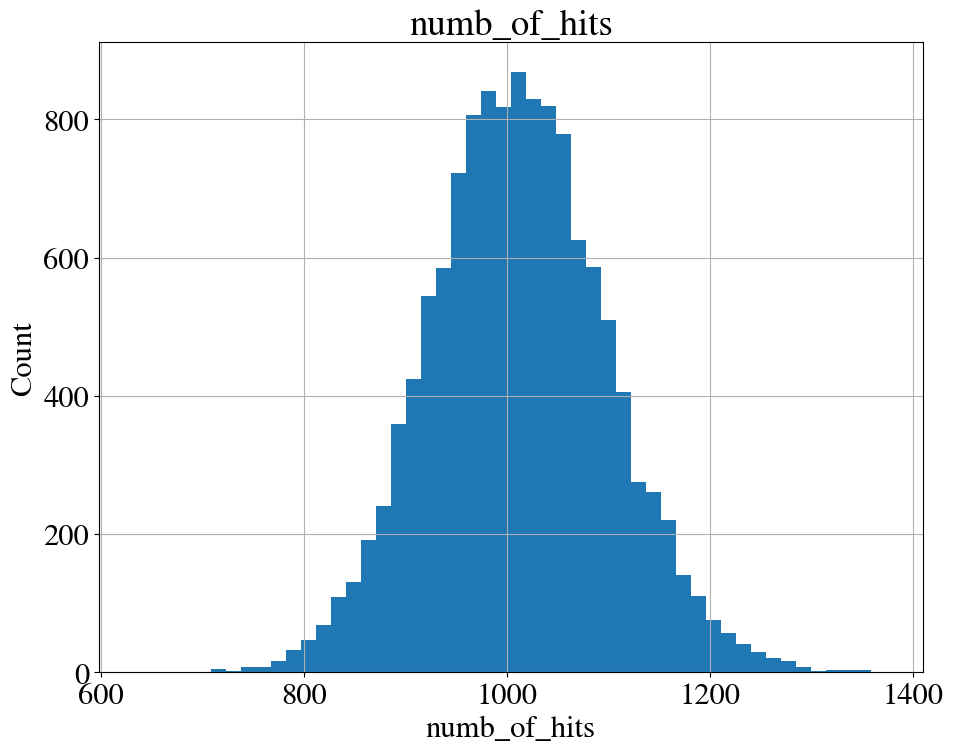

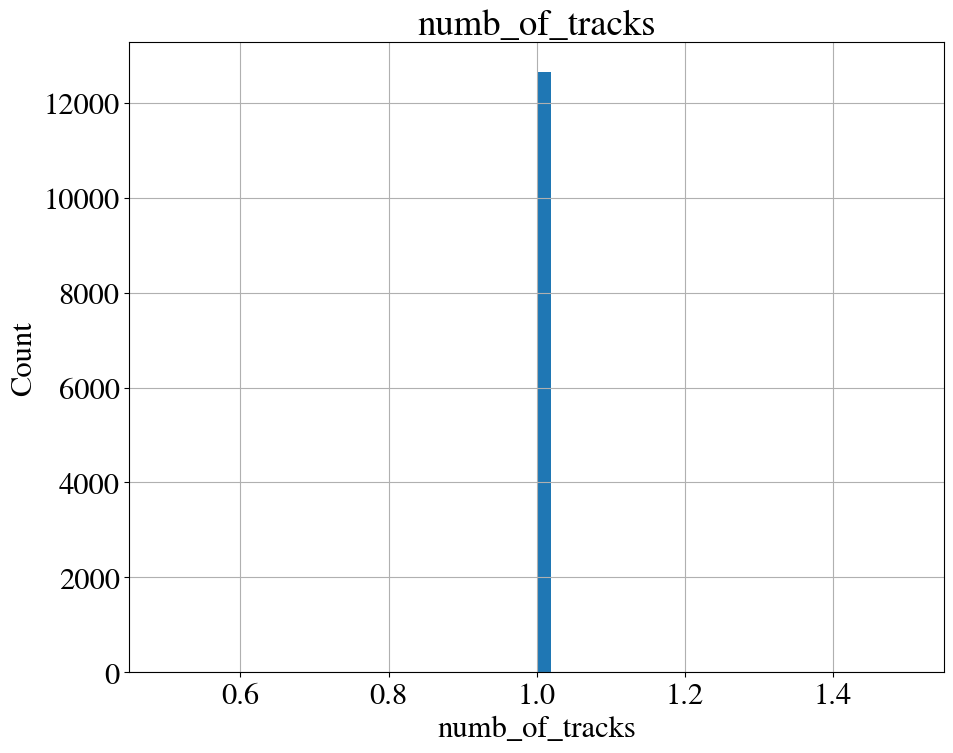

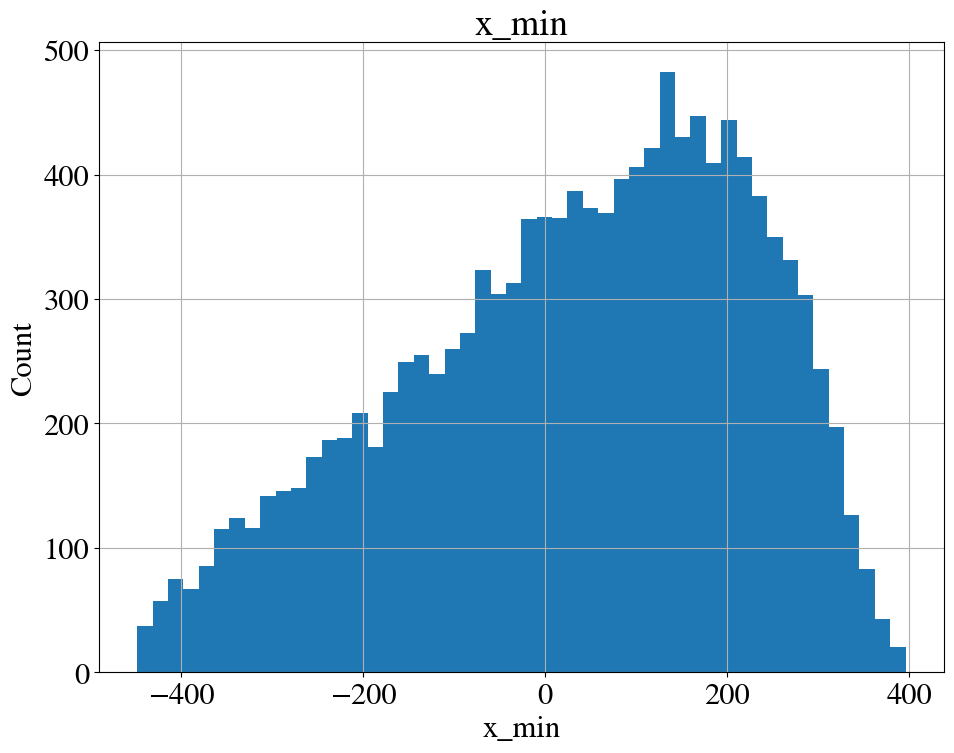

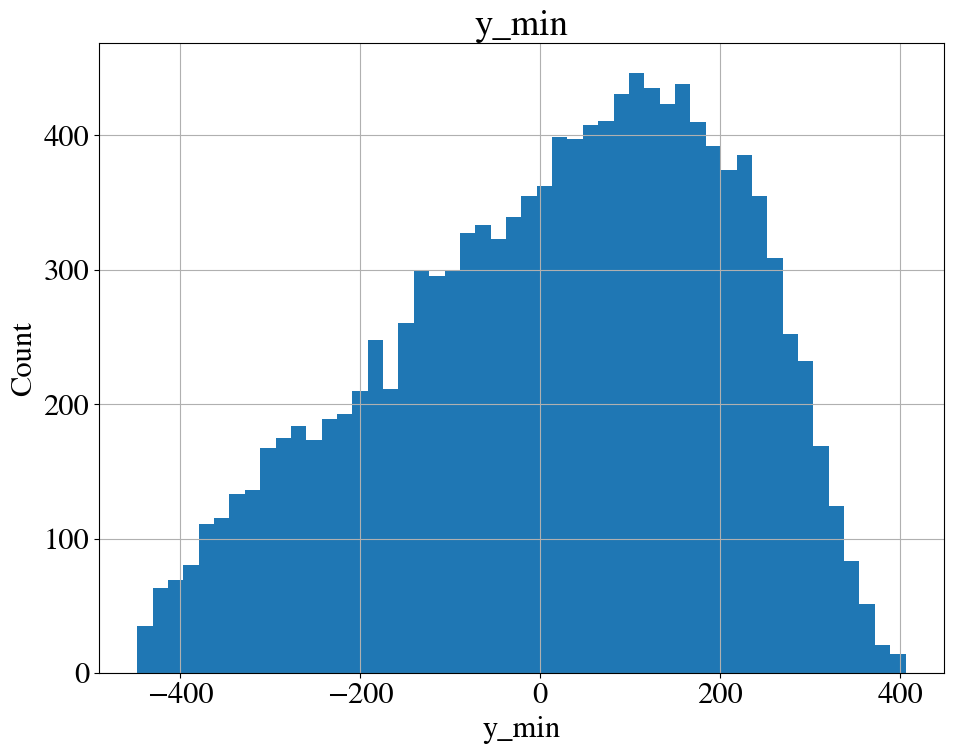

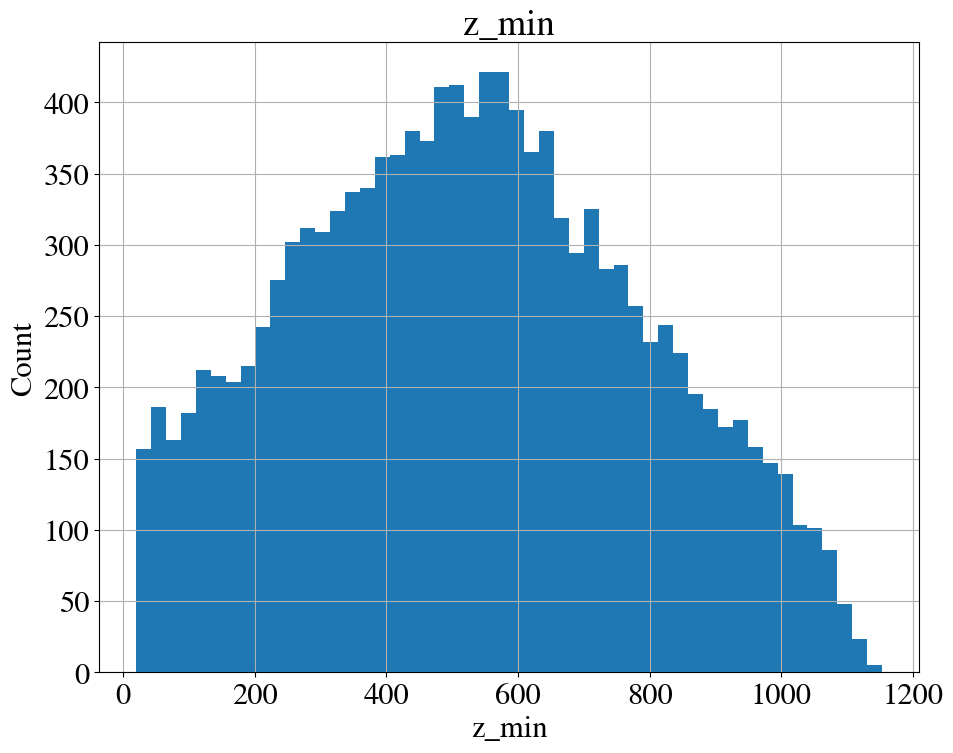

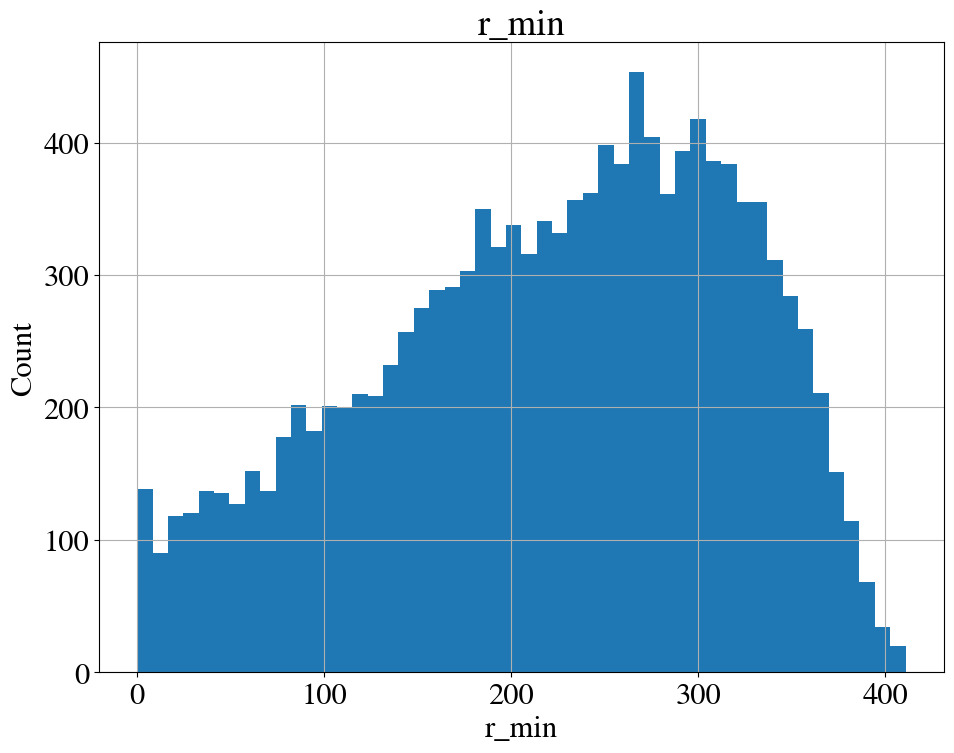

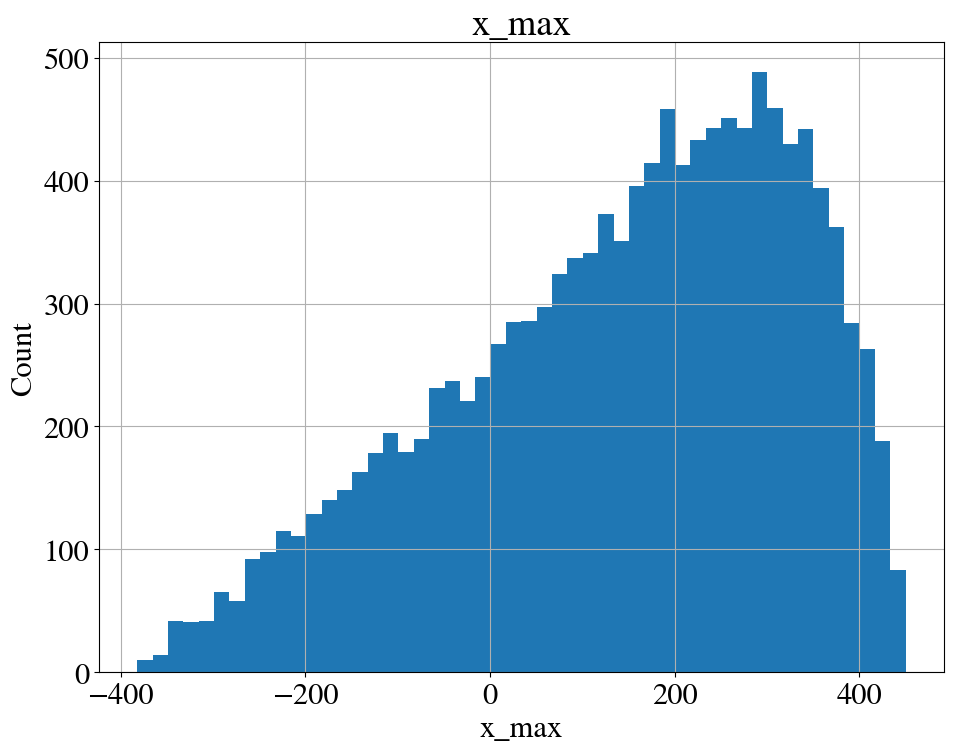

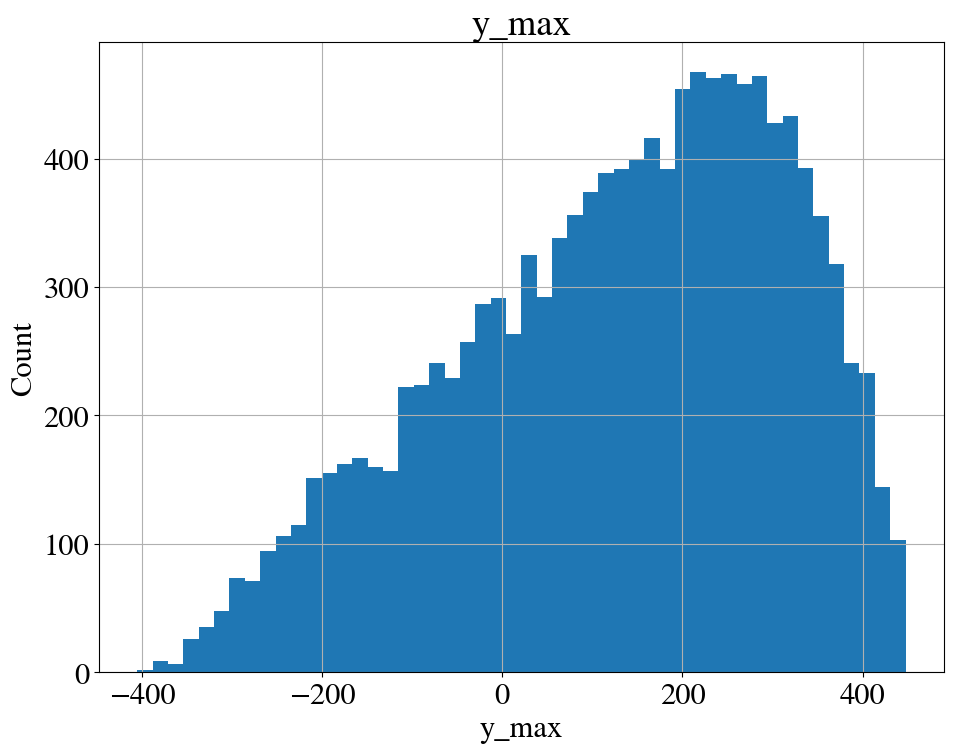

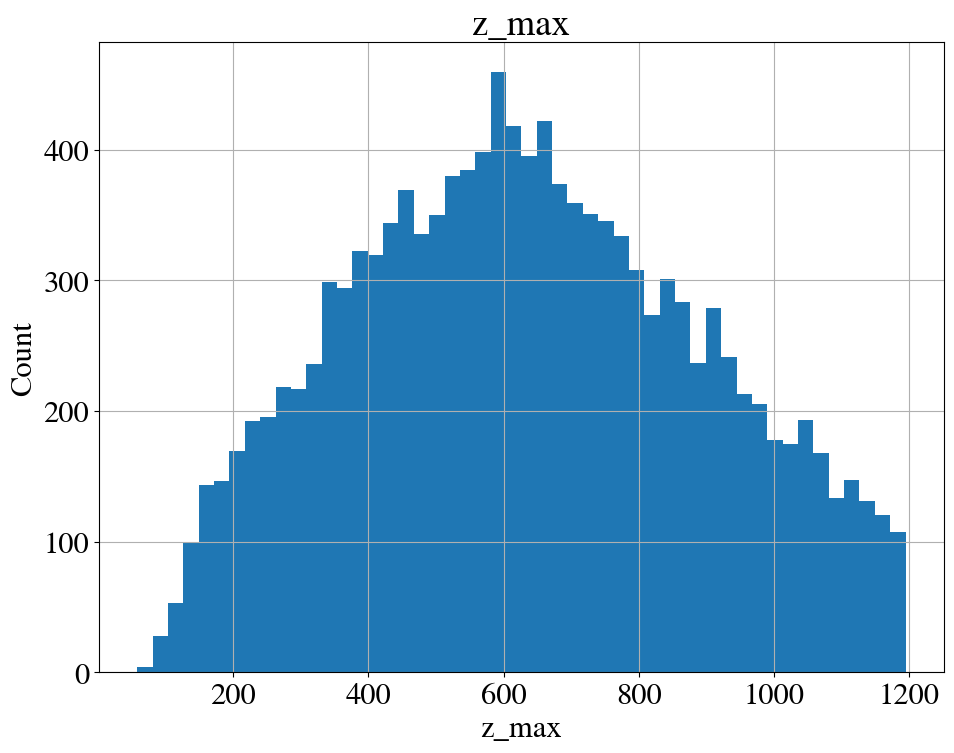

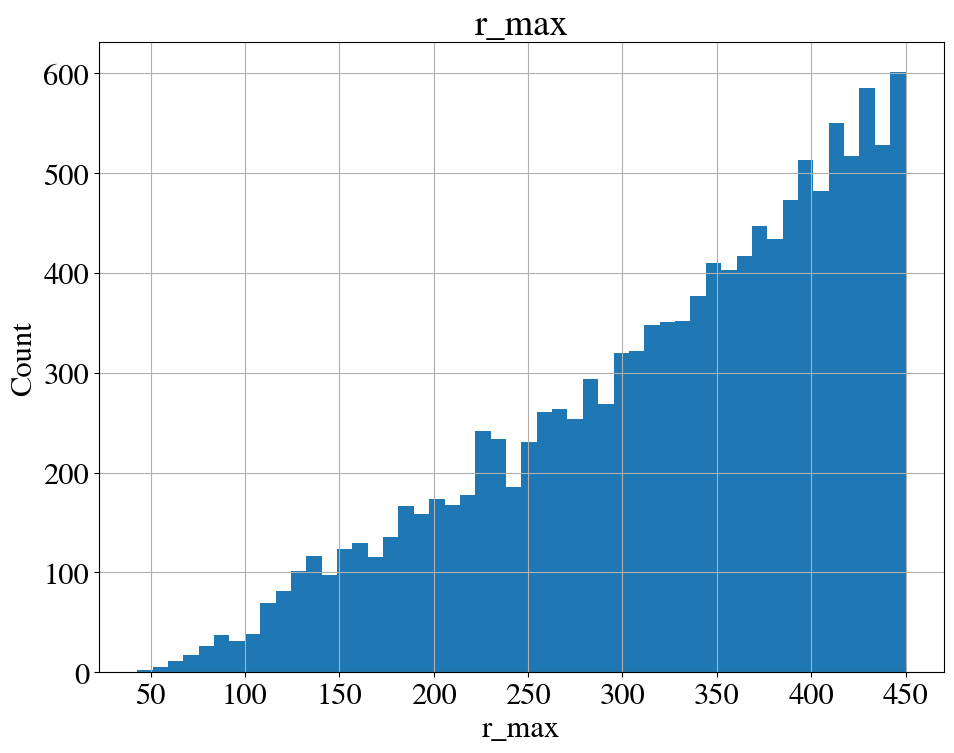

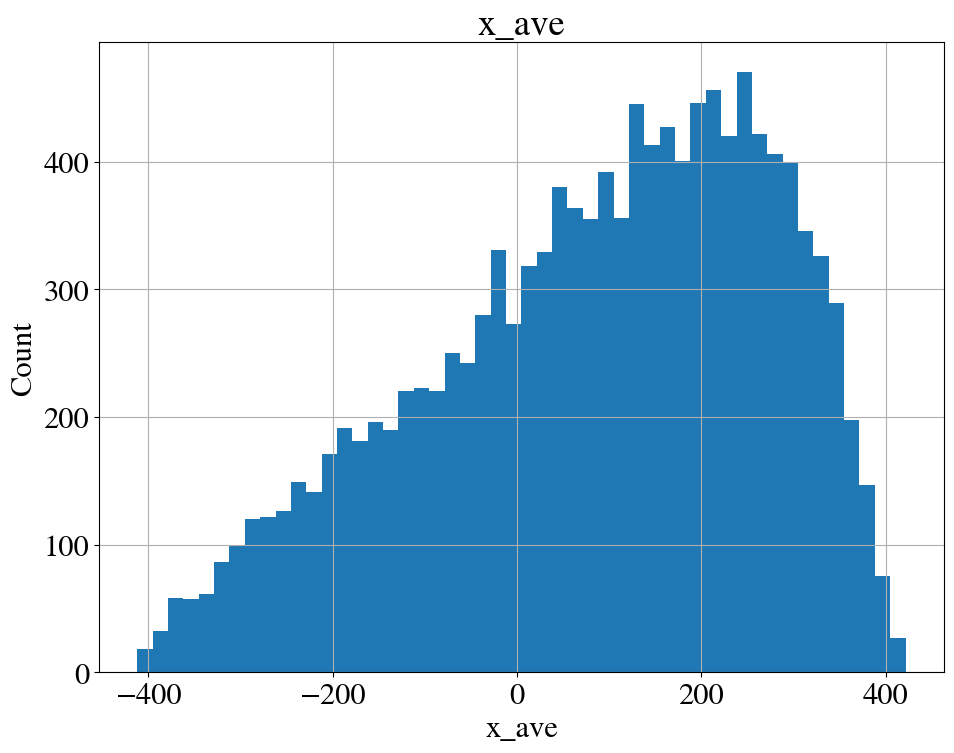

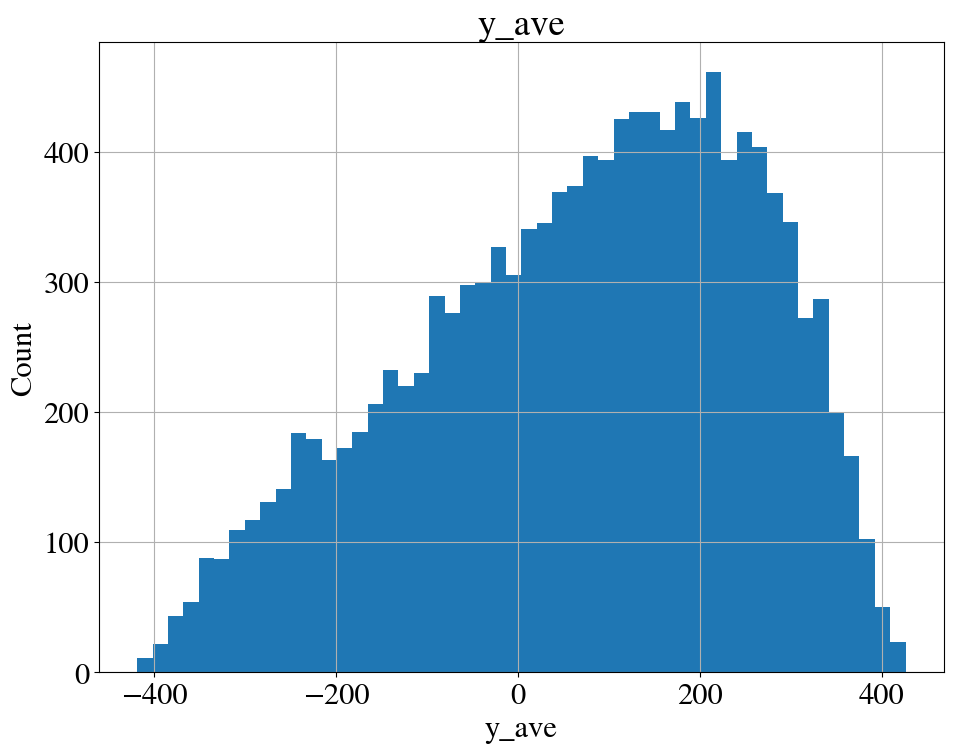

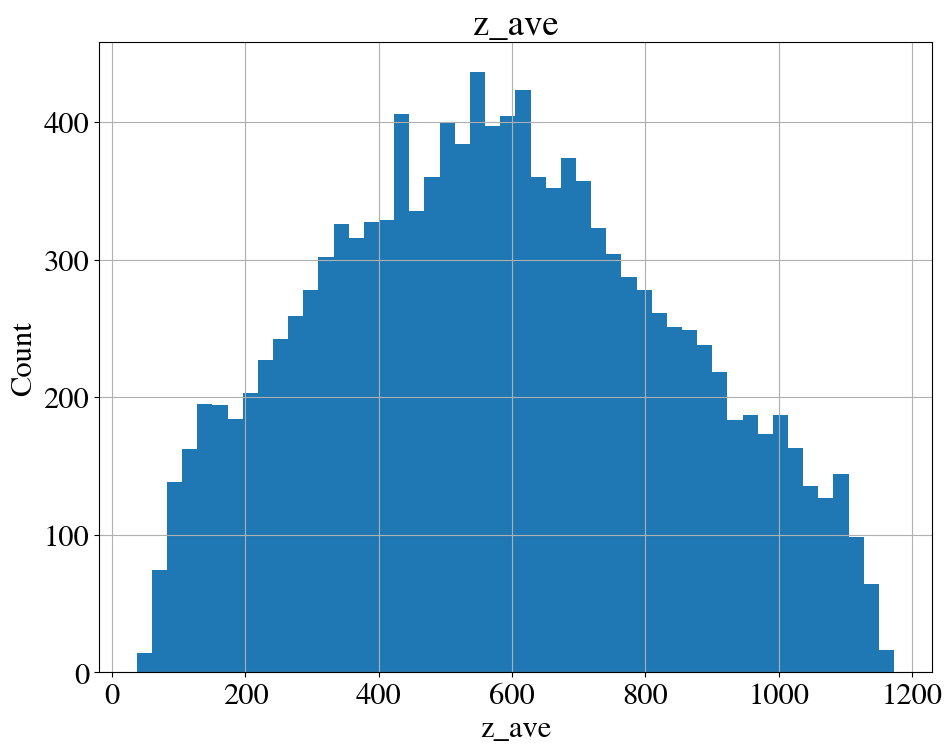

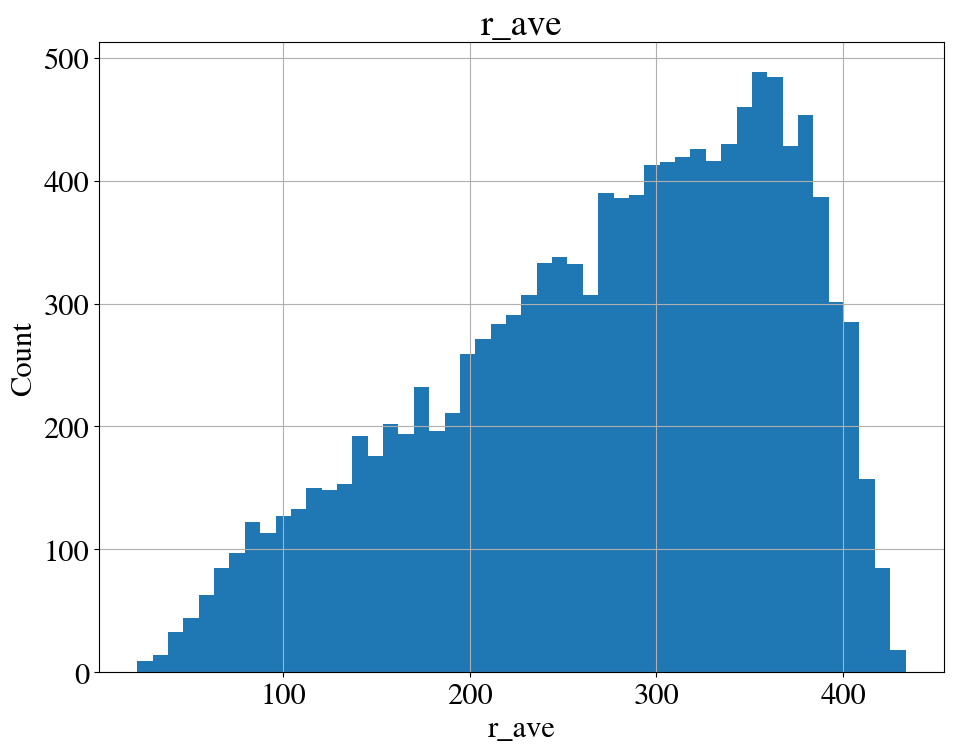

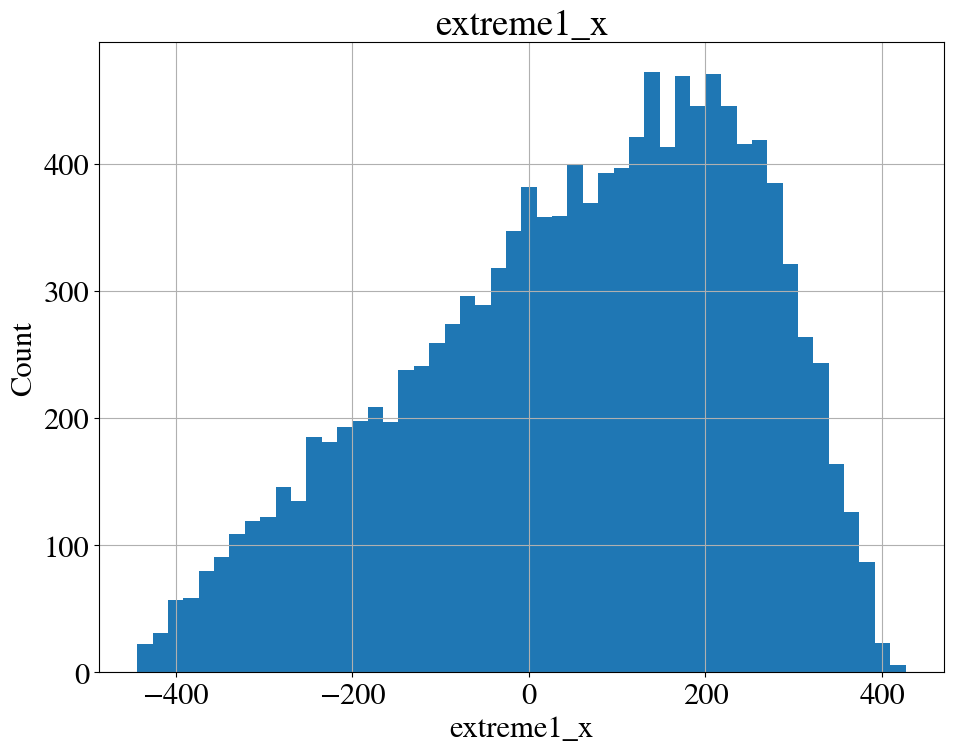

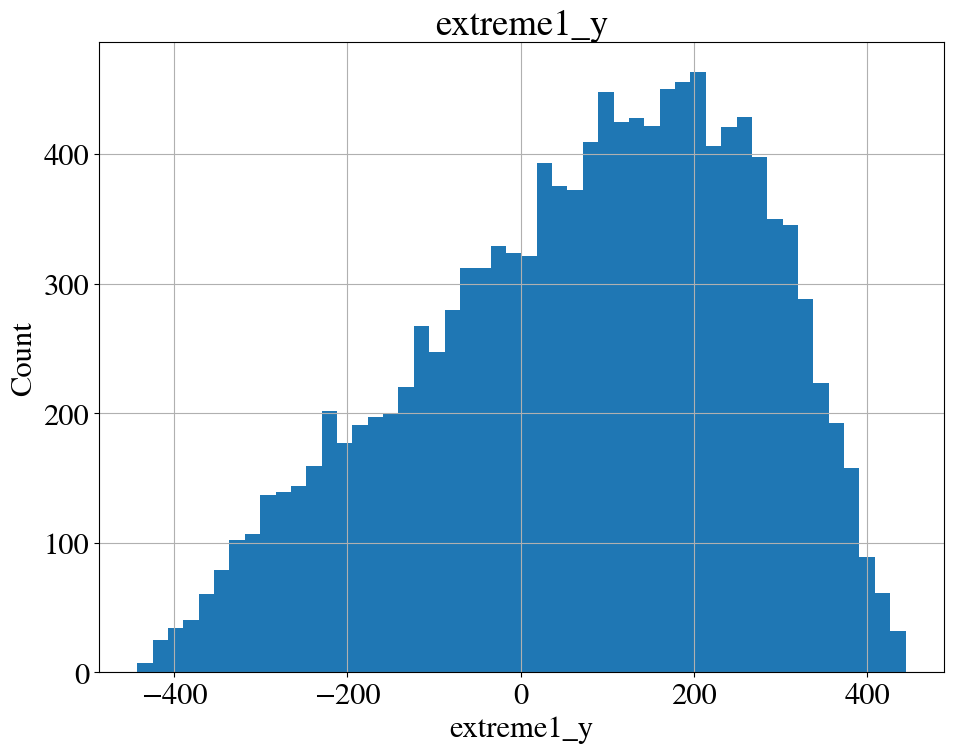

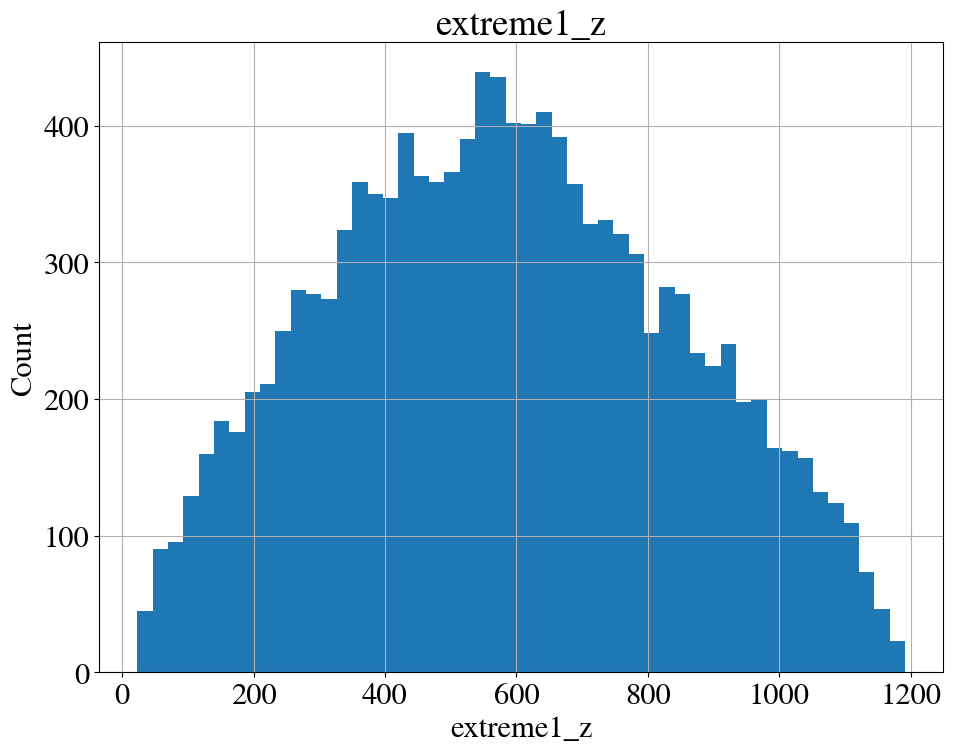

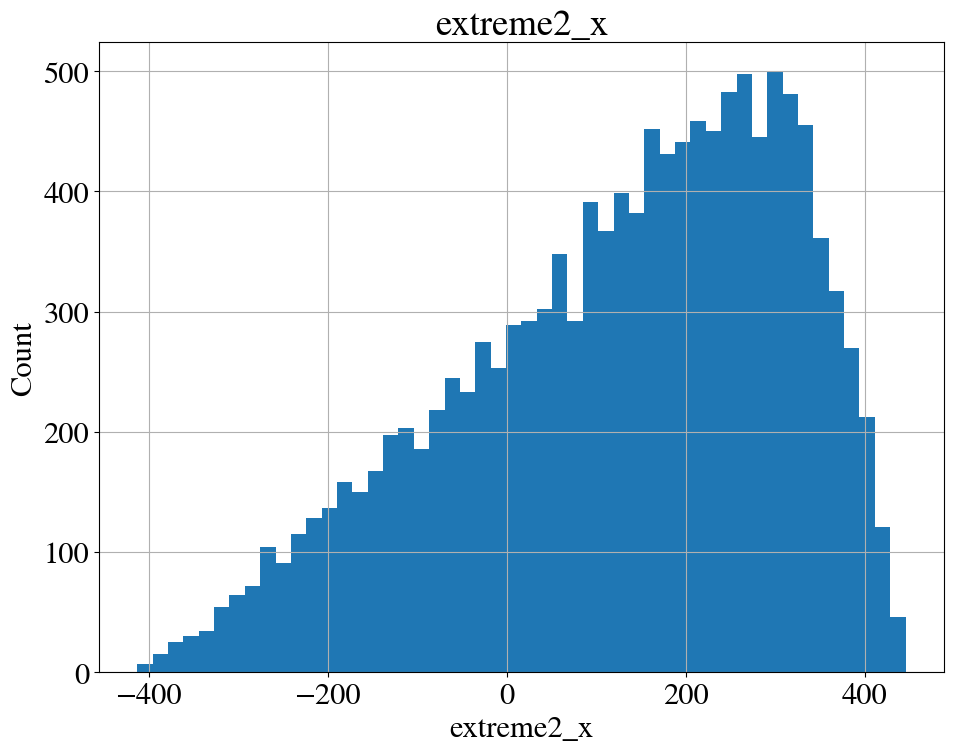

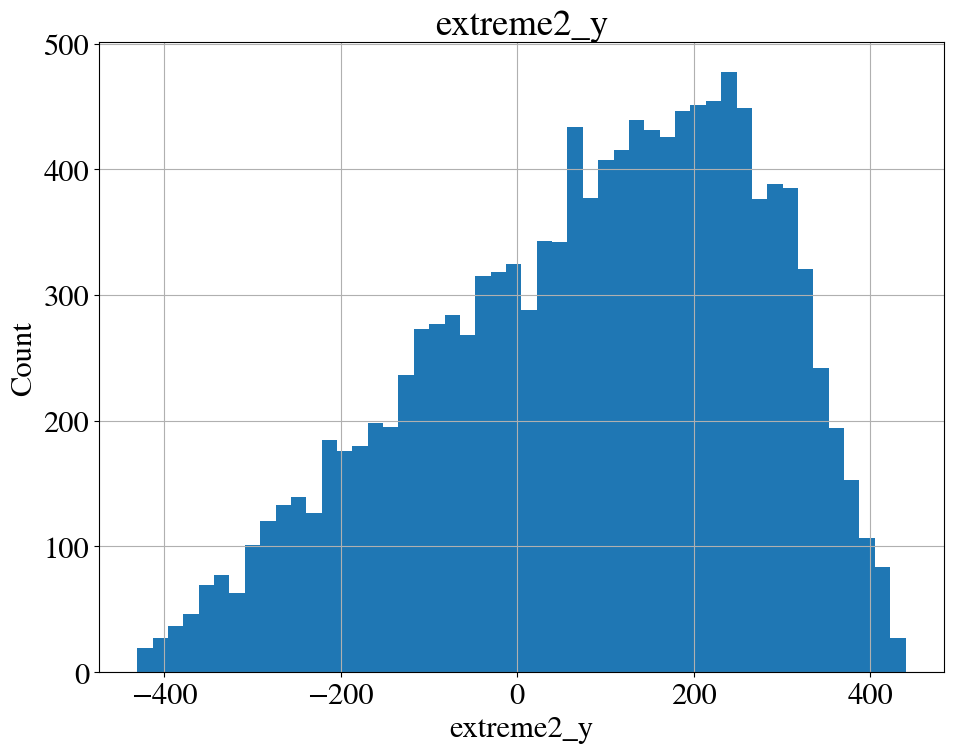

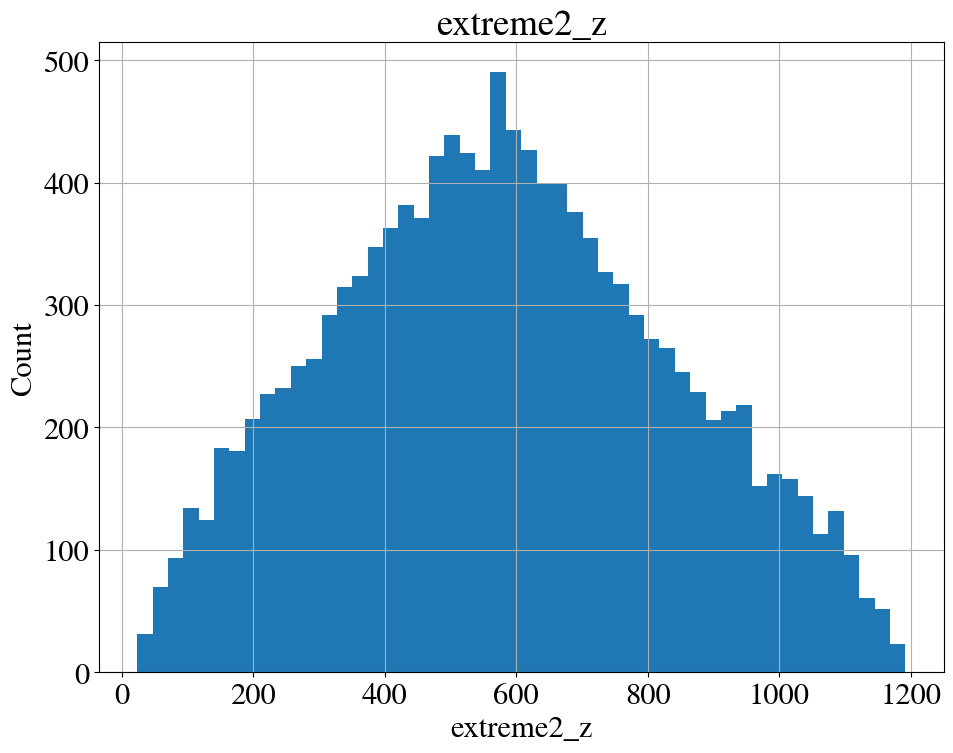

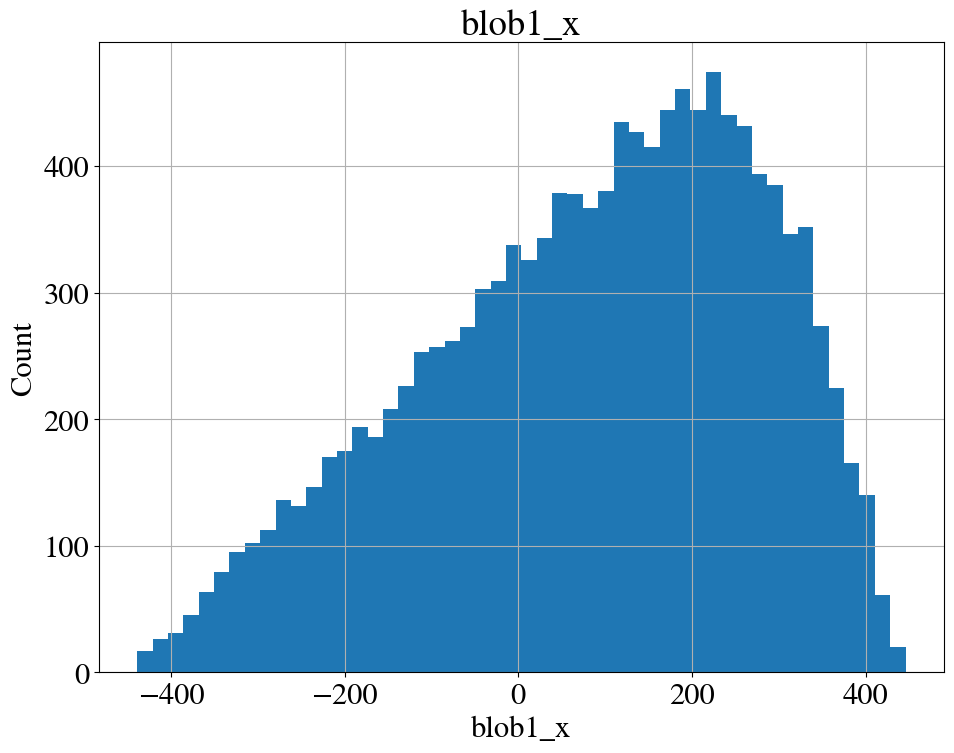

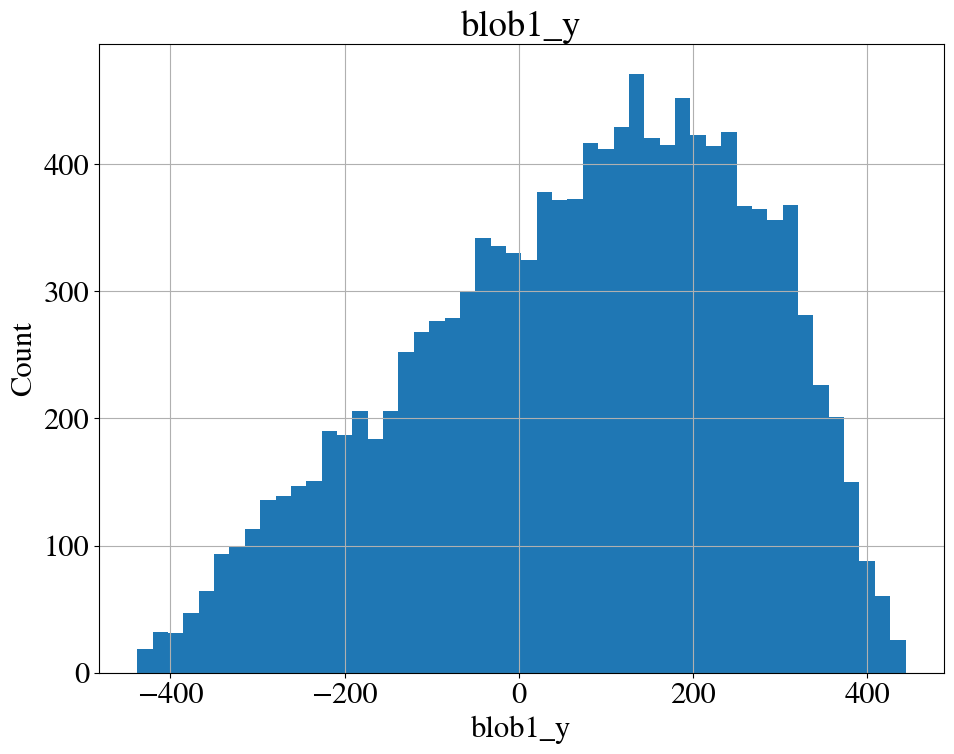

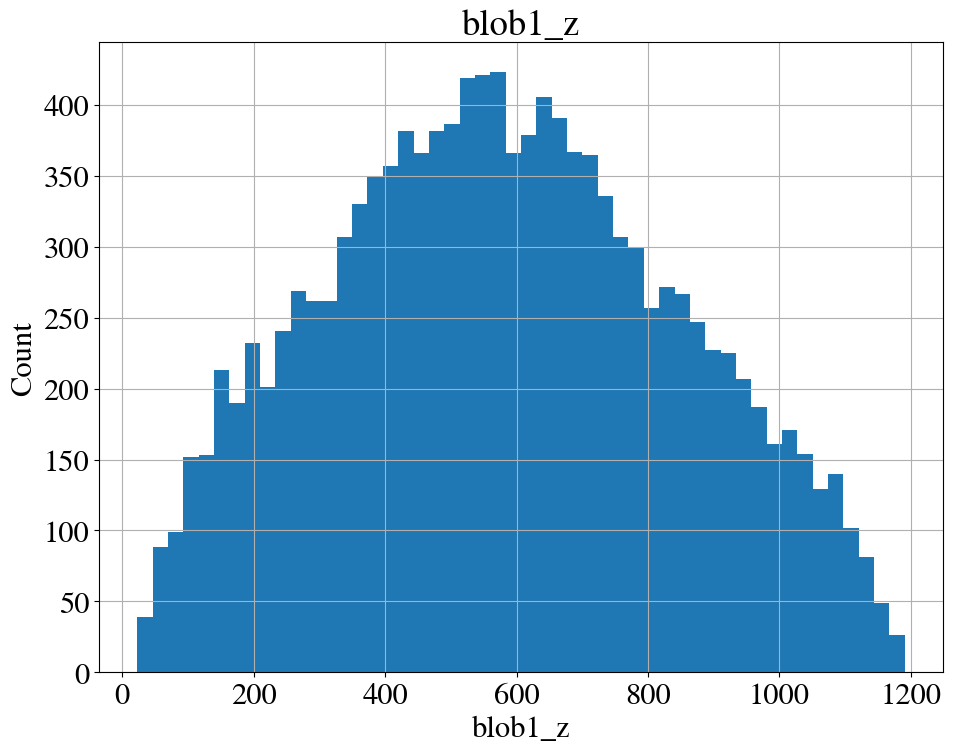

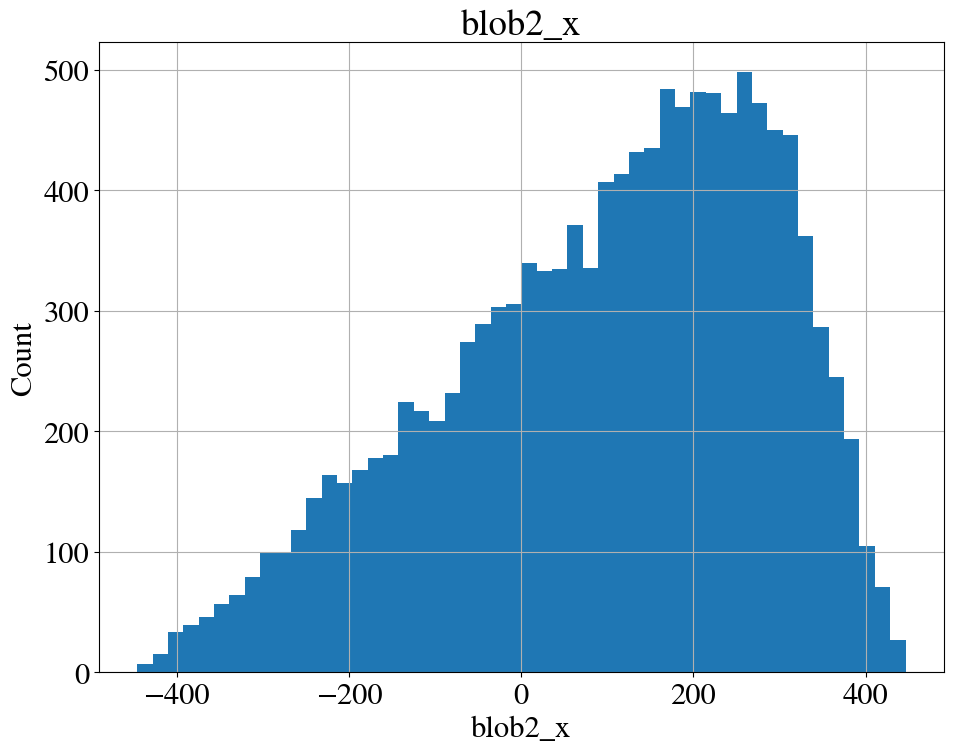

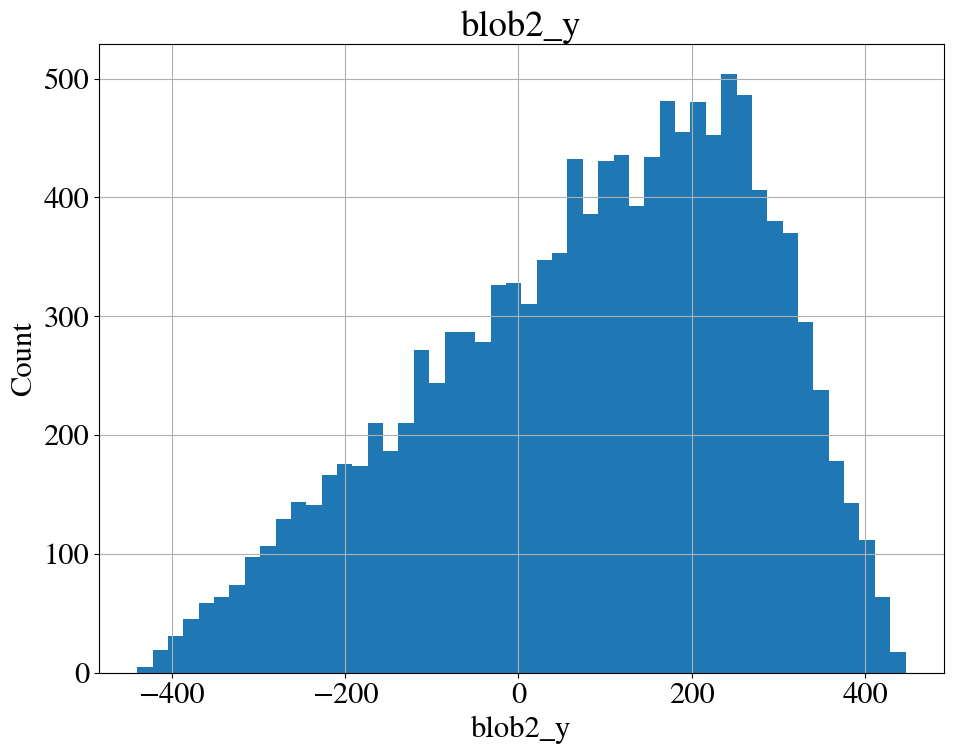

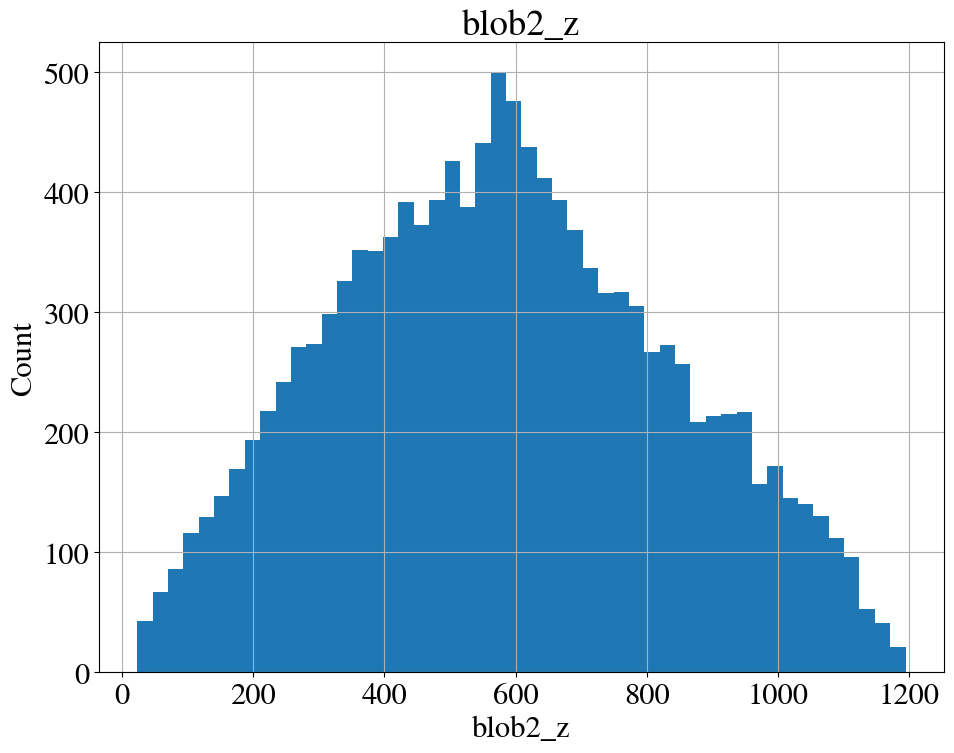

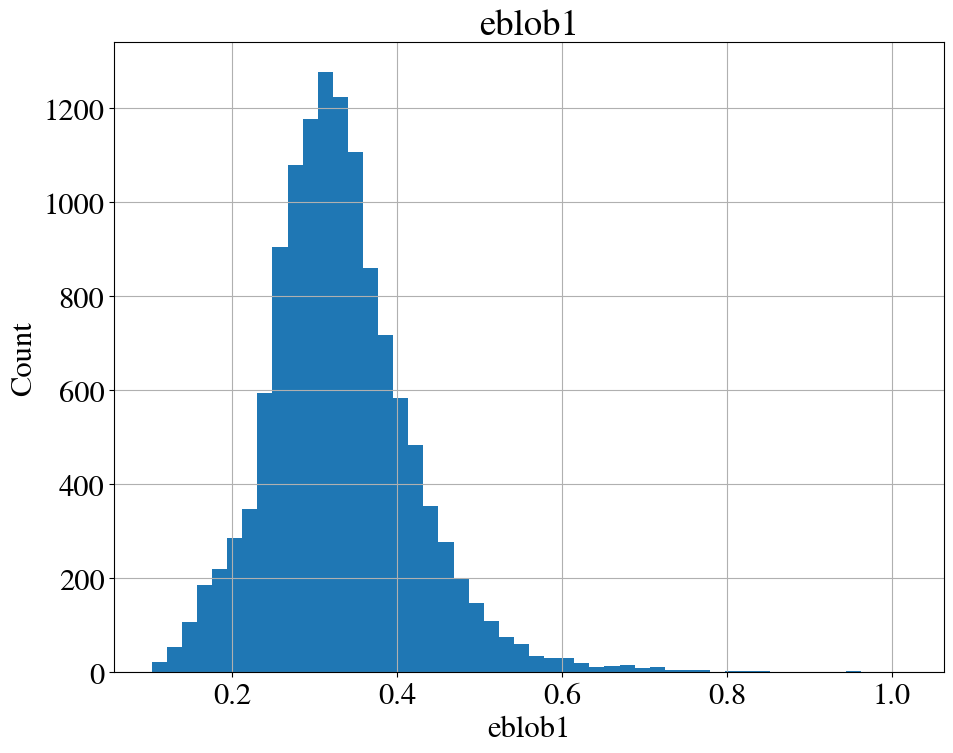

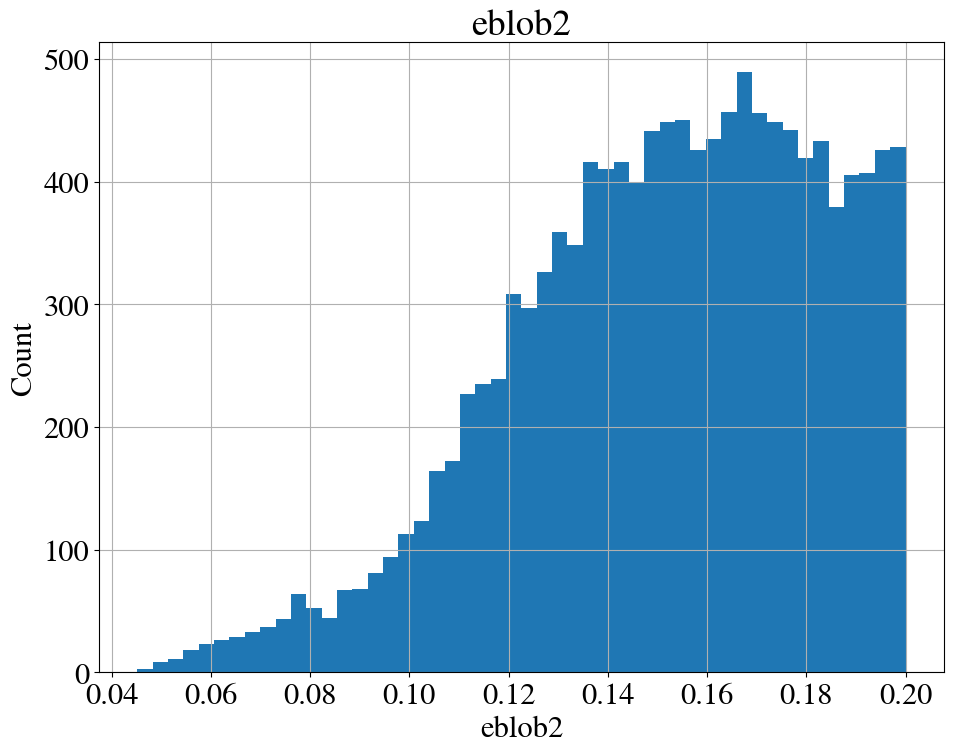

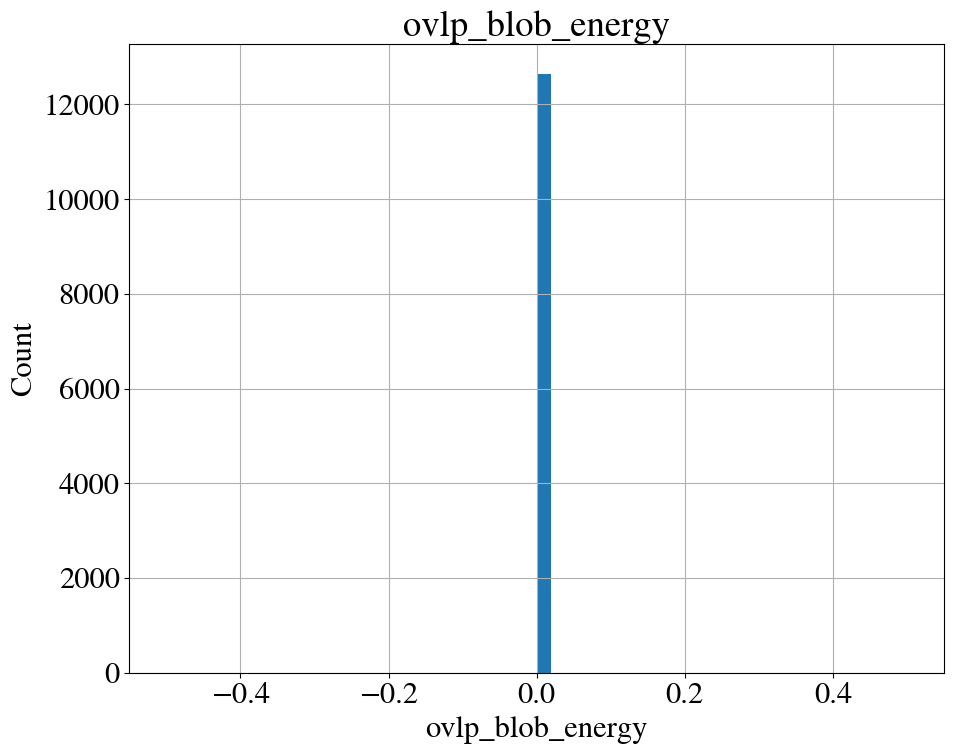

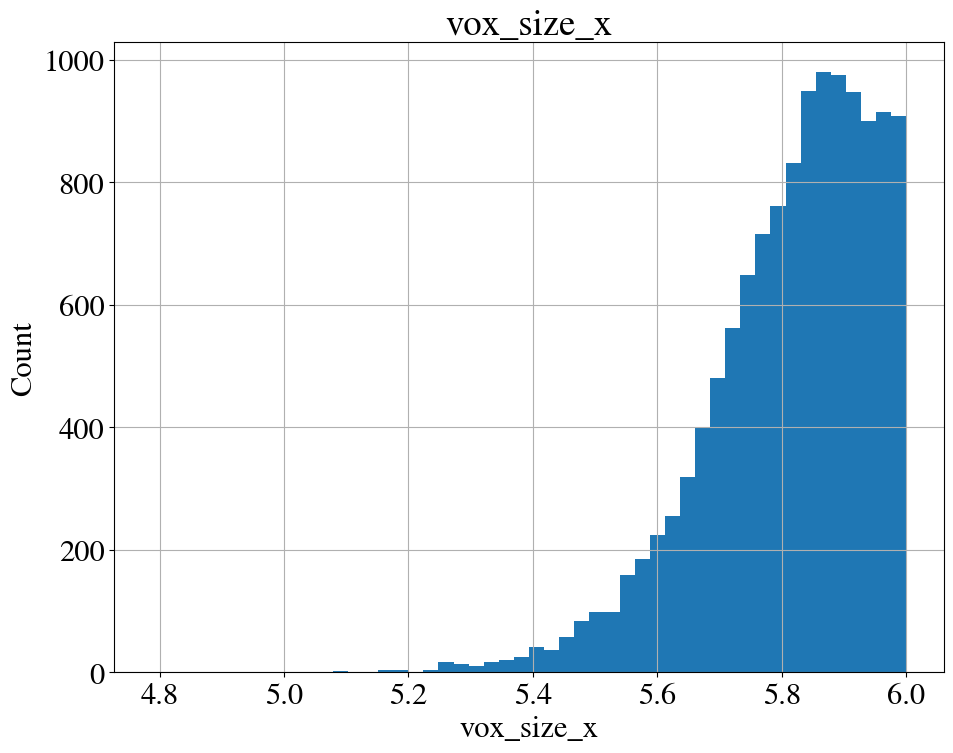

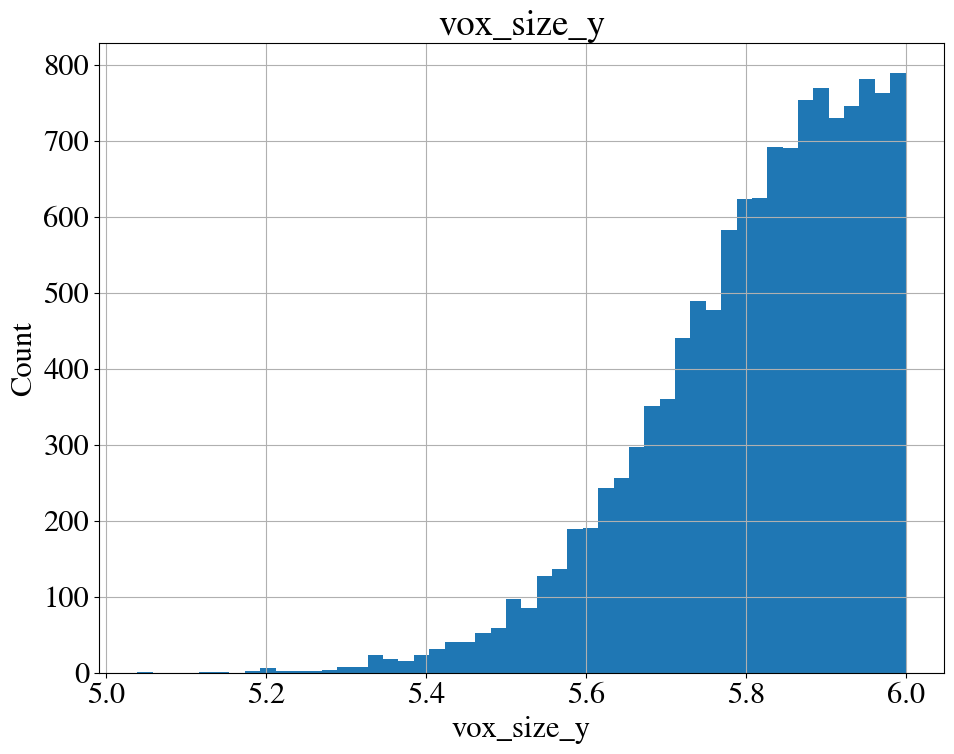

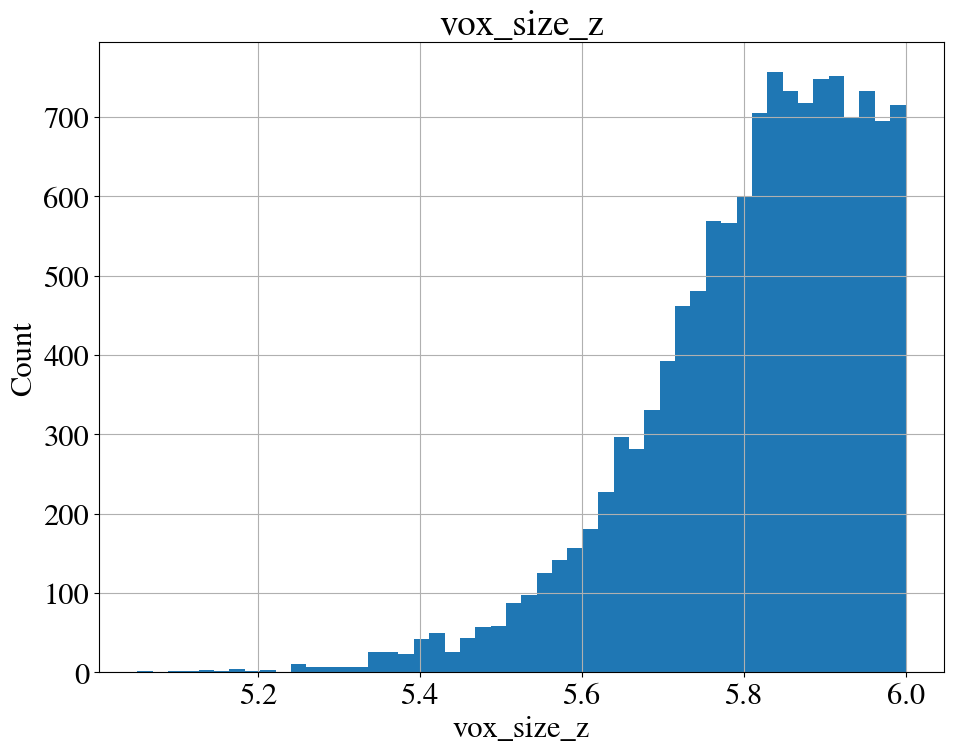

In [35]:

# Plot histograms for all columns in funky_blob2s
for col in funky_blob2s.columns:
    plt.figure()
    funky_blob2s[col].hist(bins=50)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Save event ids to a new file
np.save('MC_truth_FOM/FOM_funky_blobs.npy', funky_blob2s['event'].values)



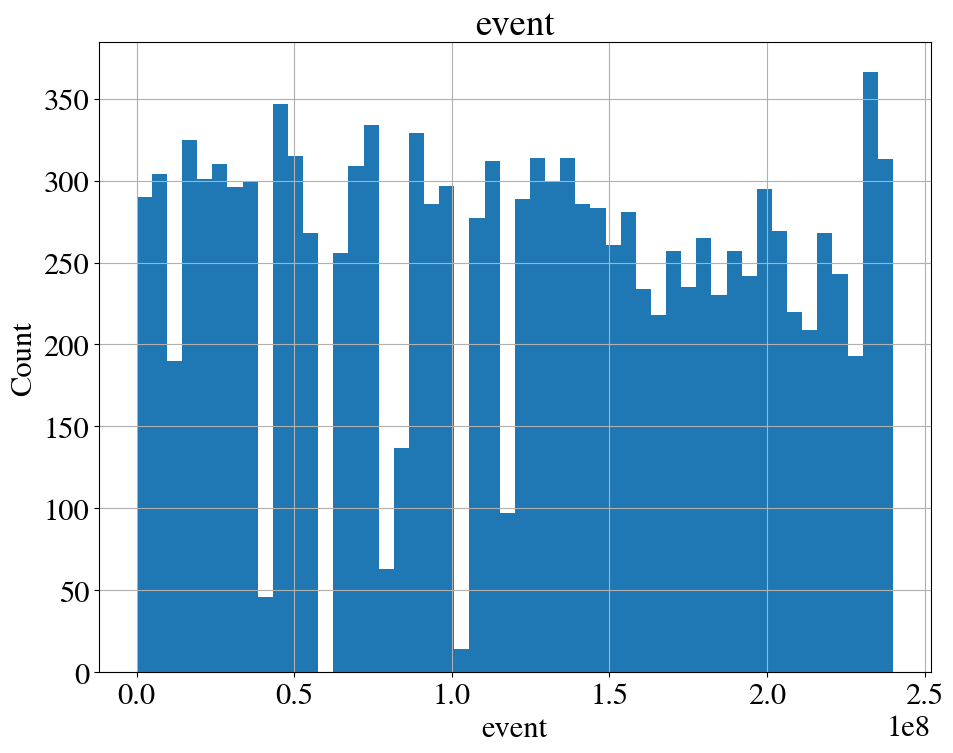

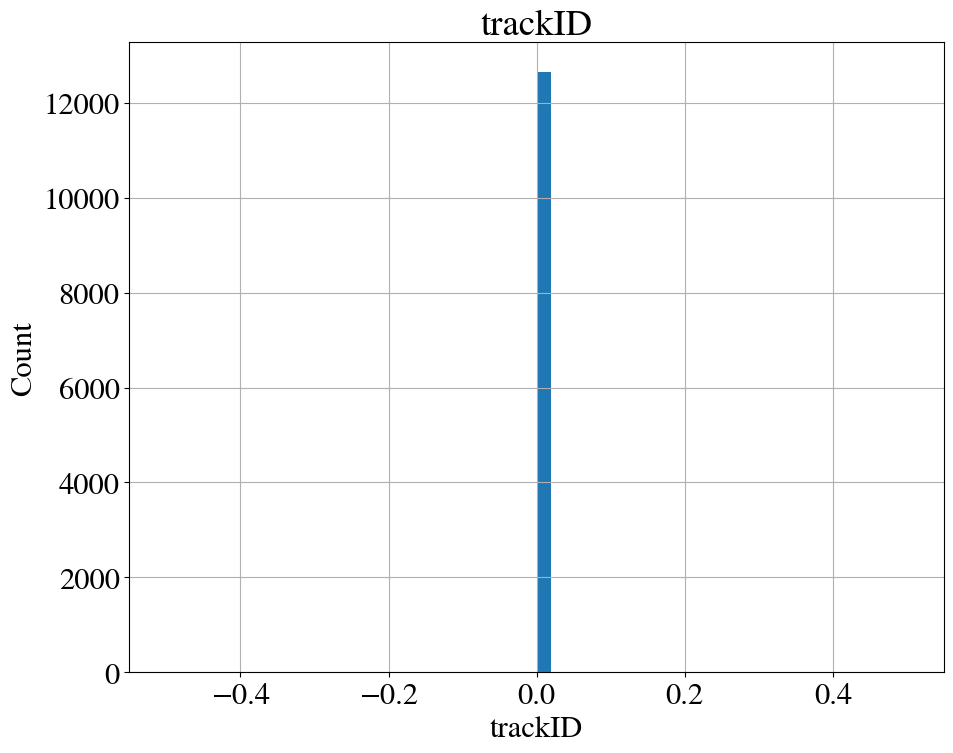

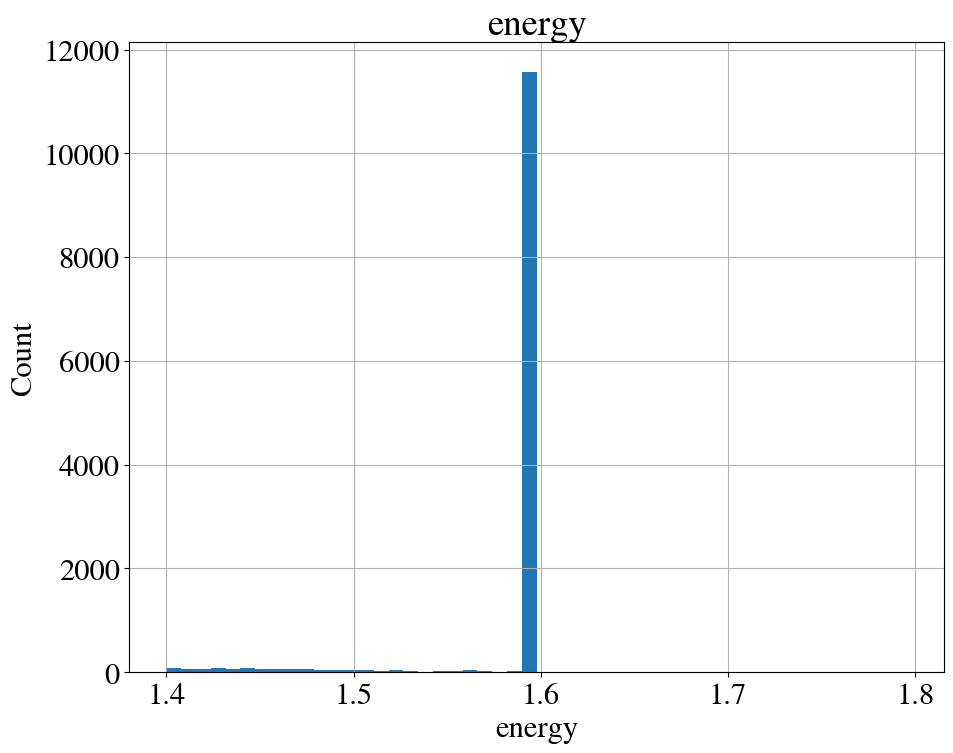

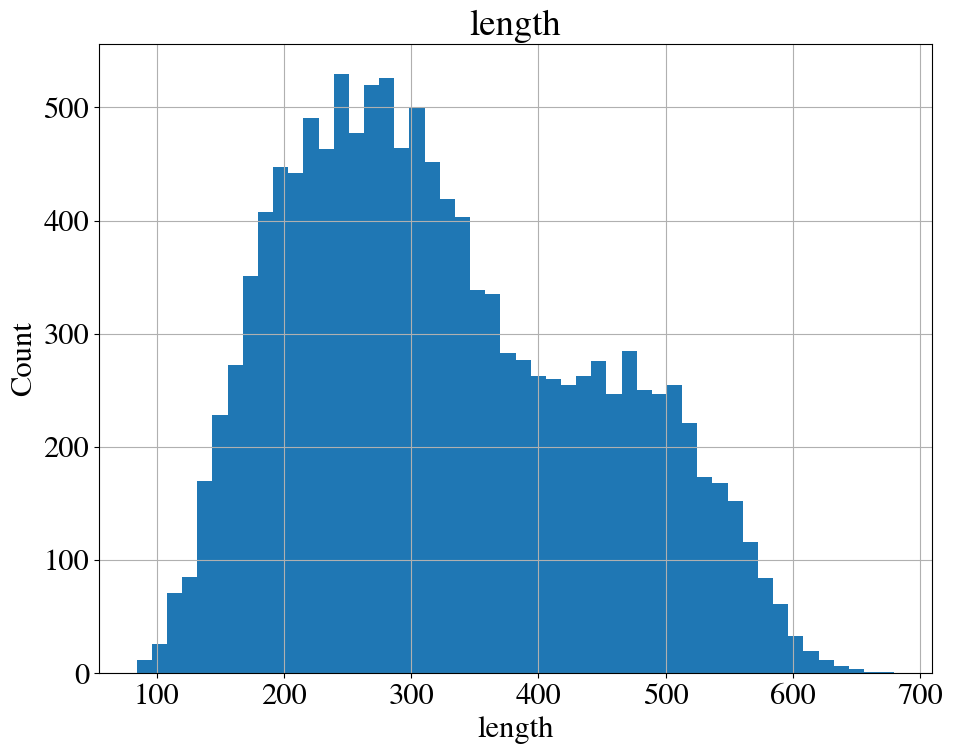

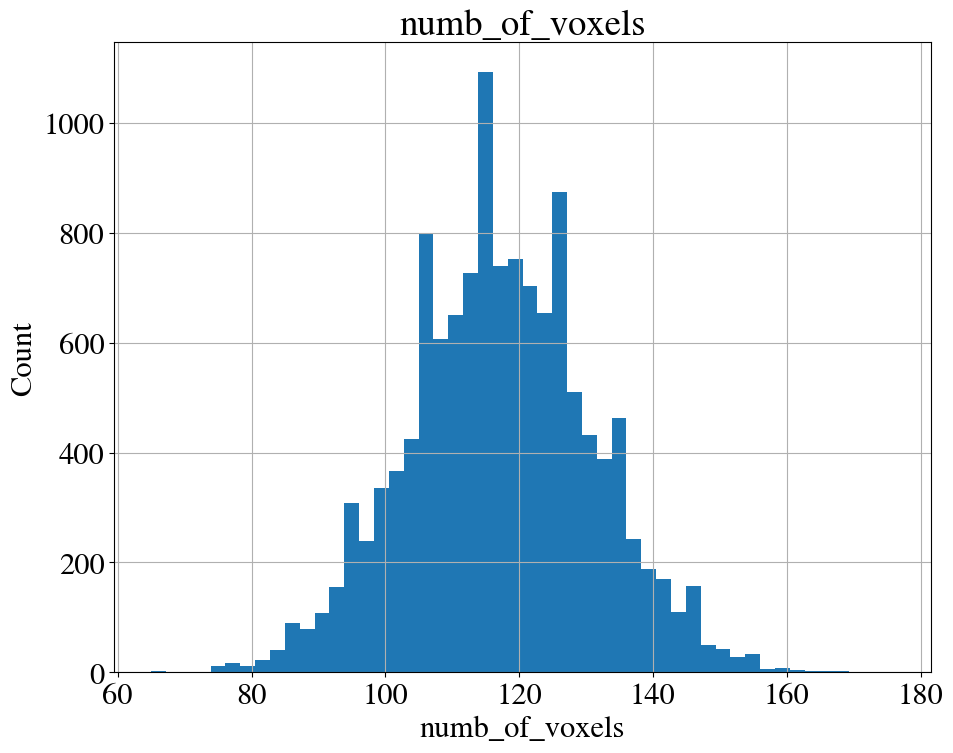

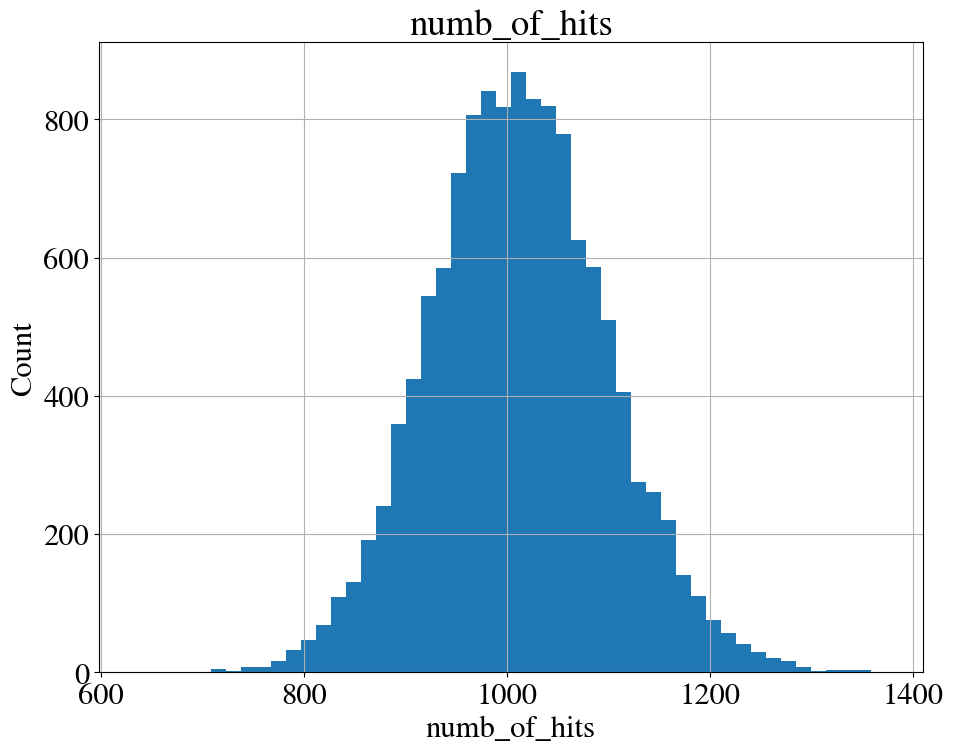

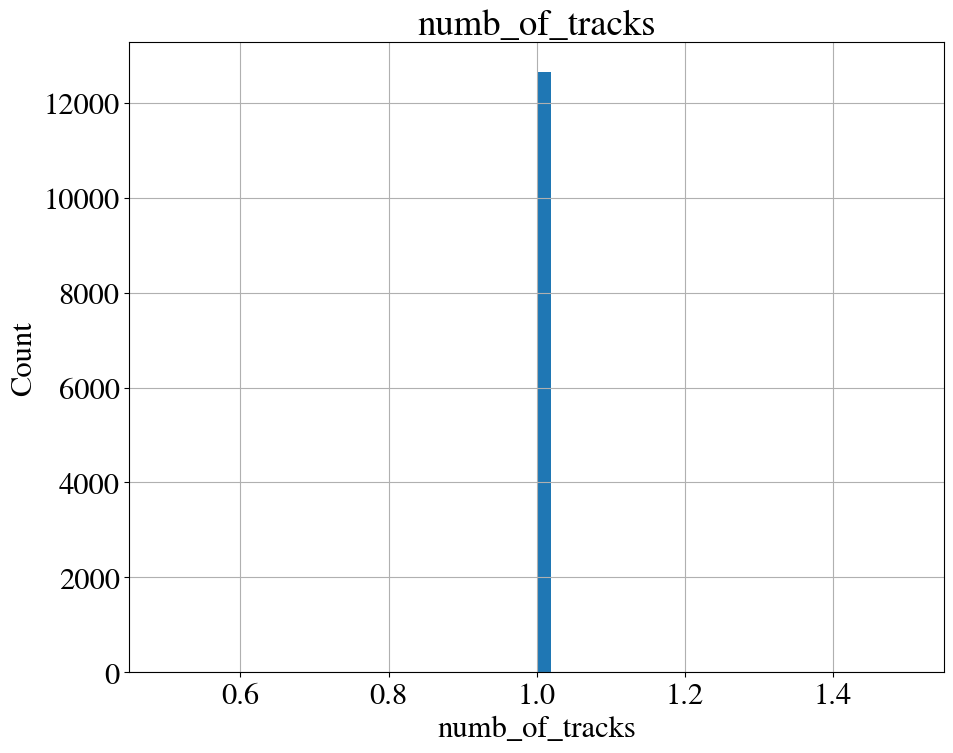

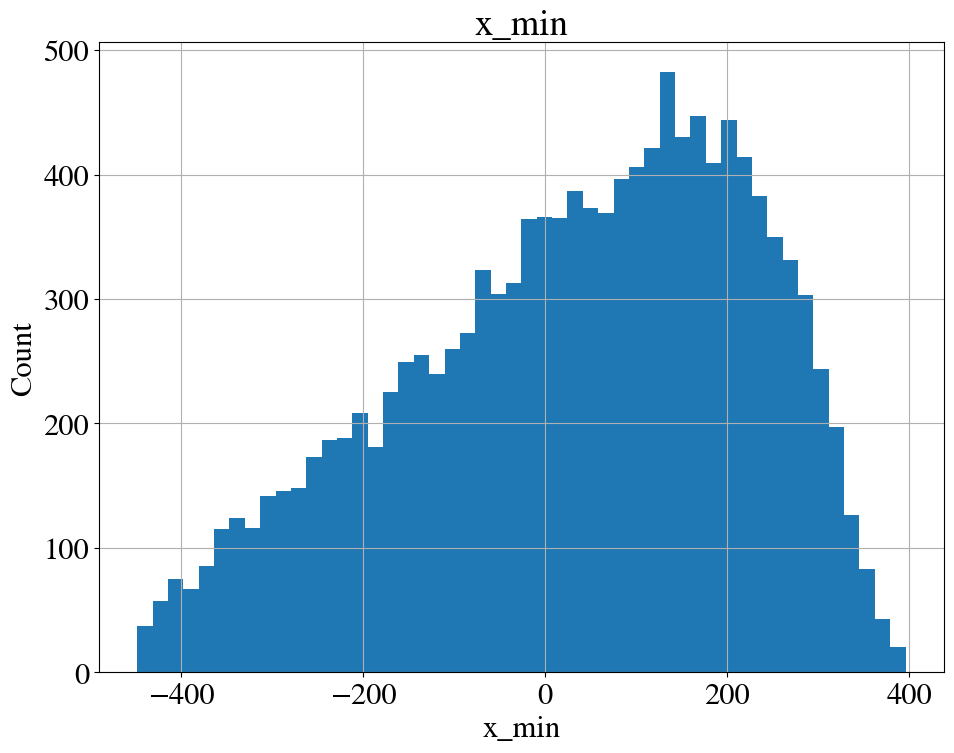

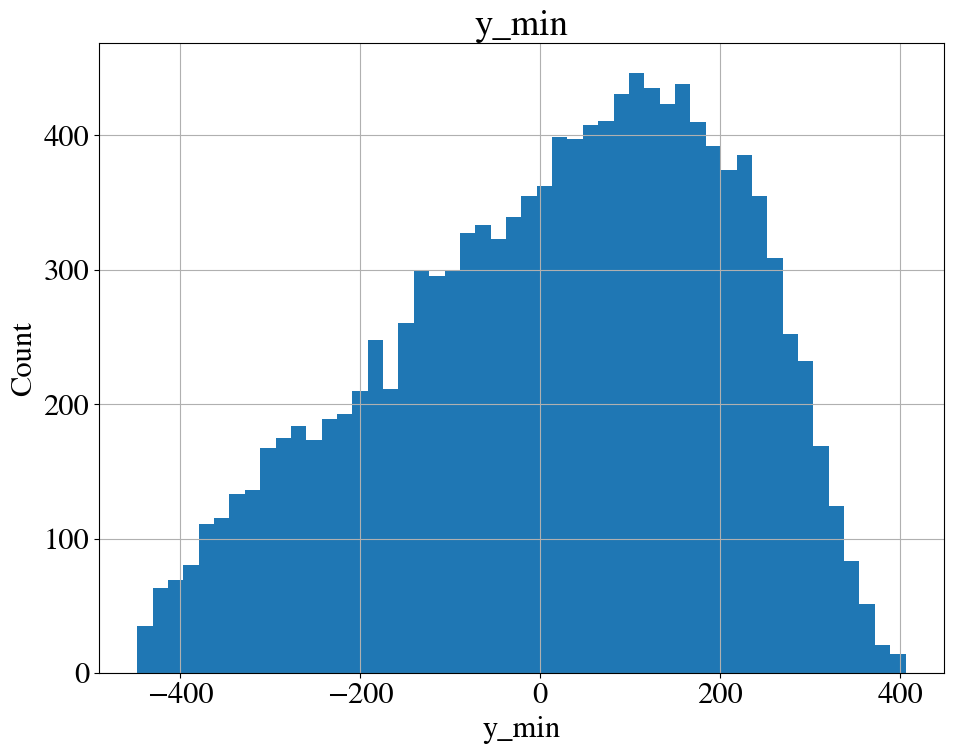

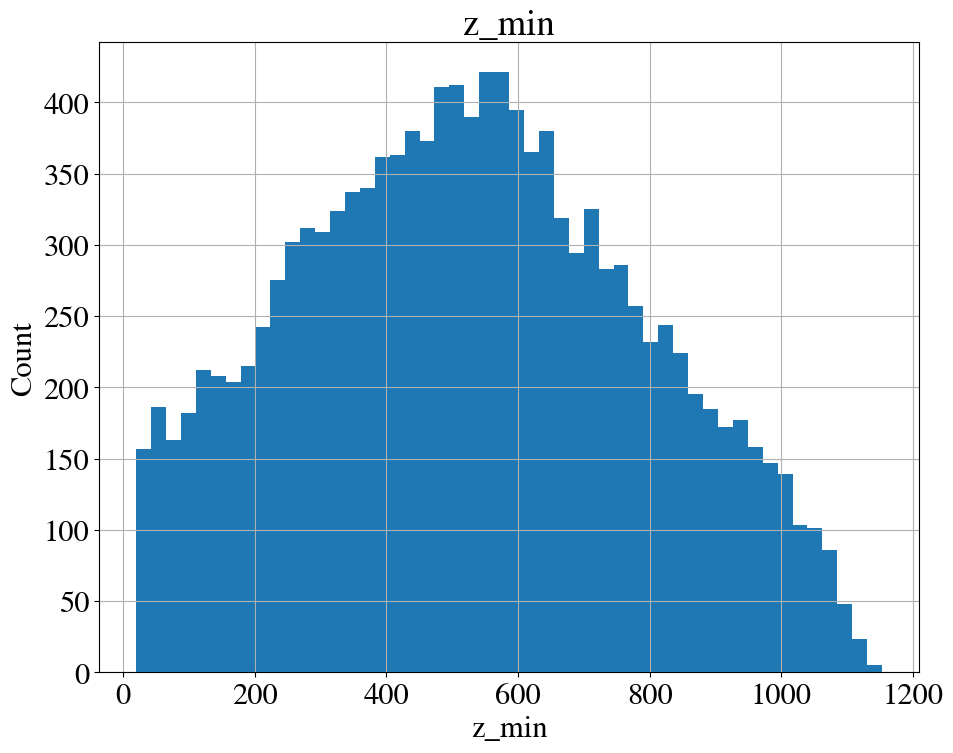

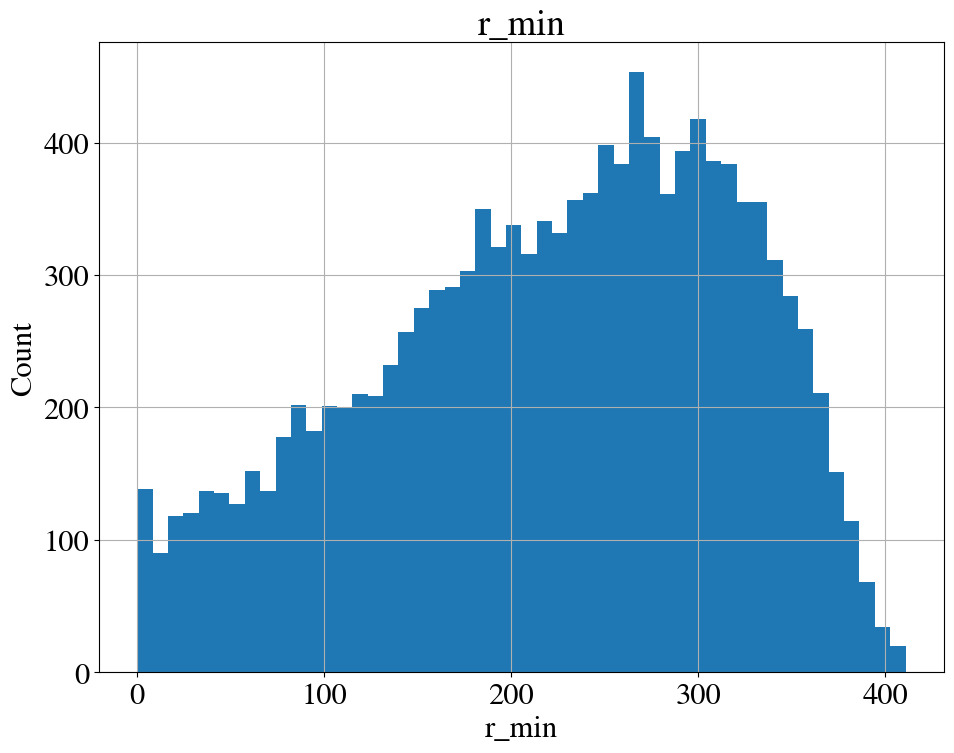

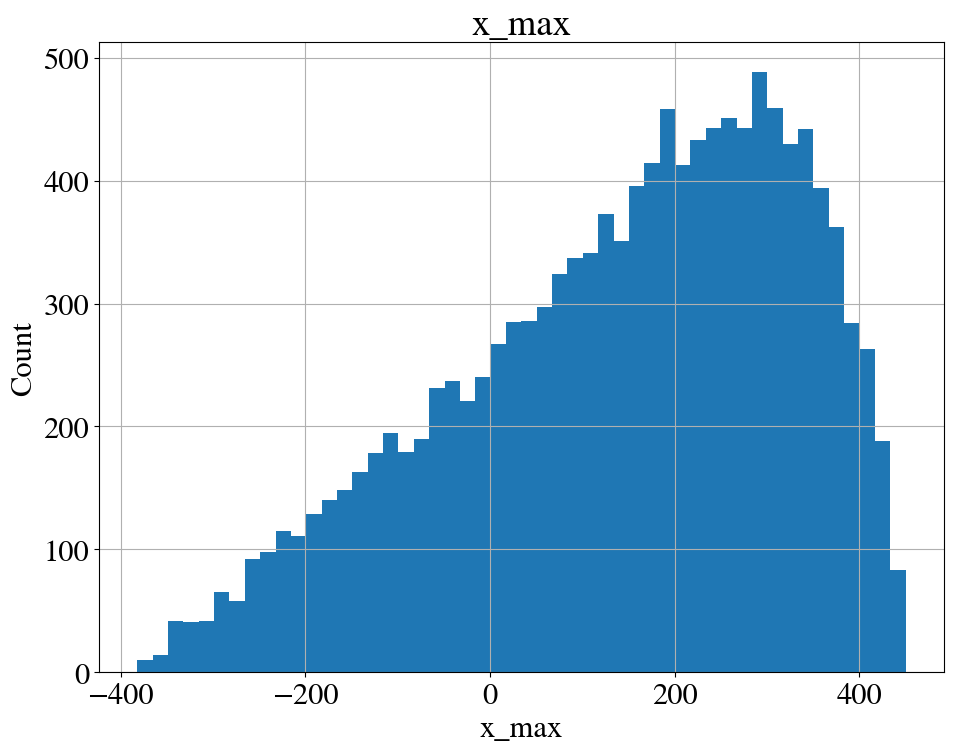

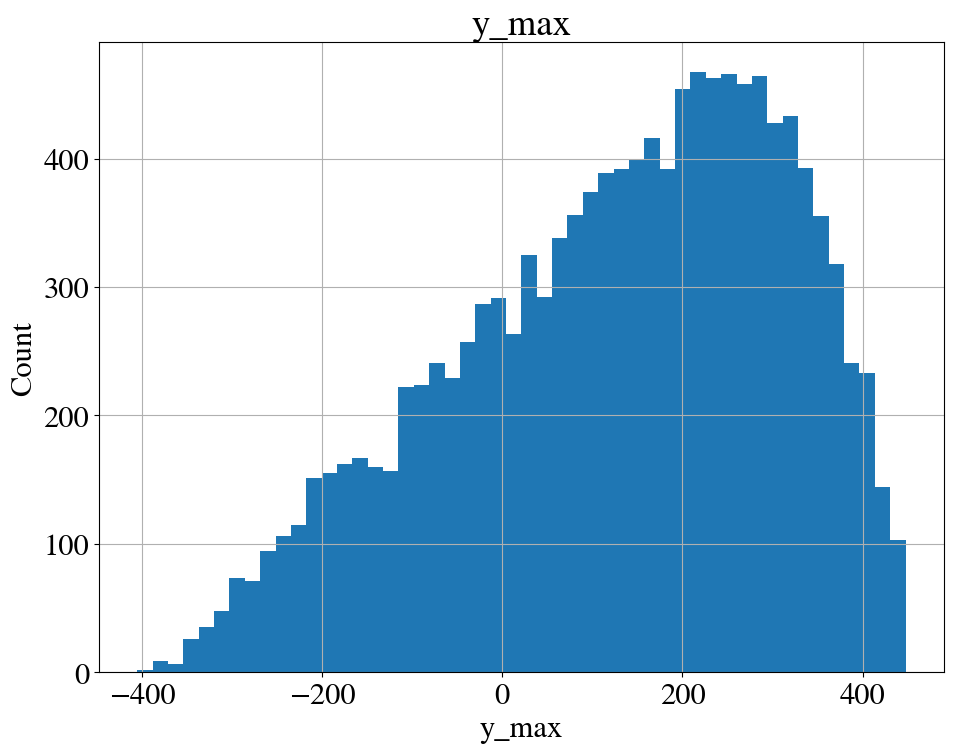

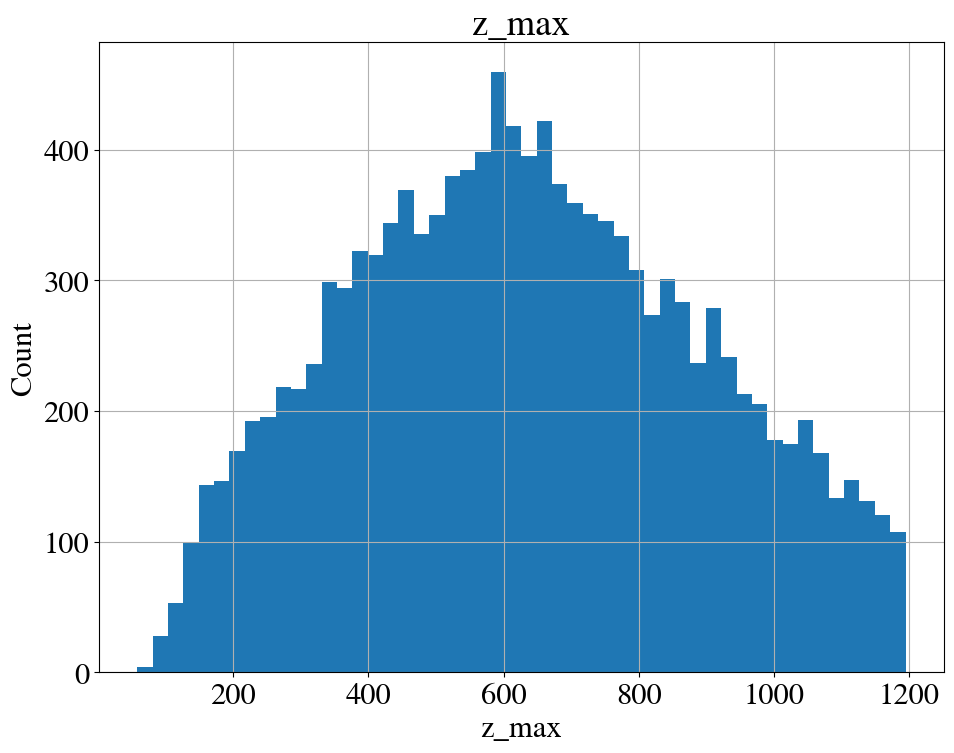

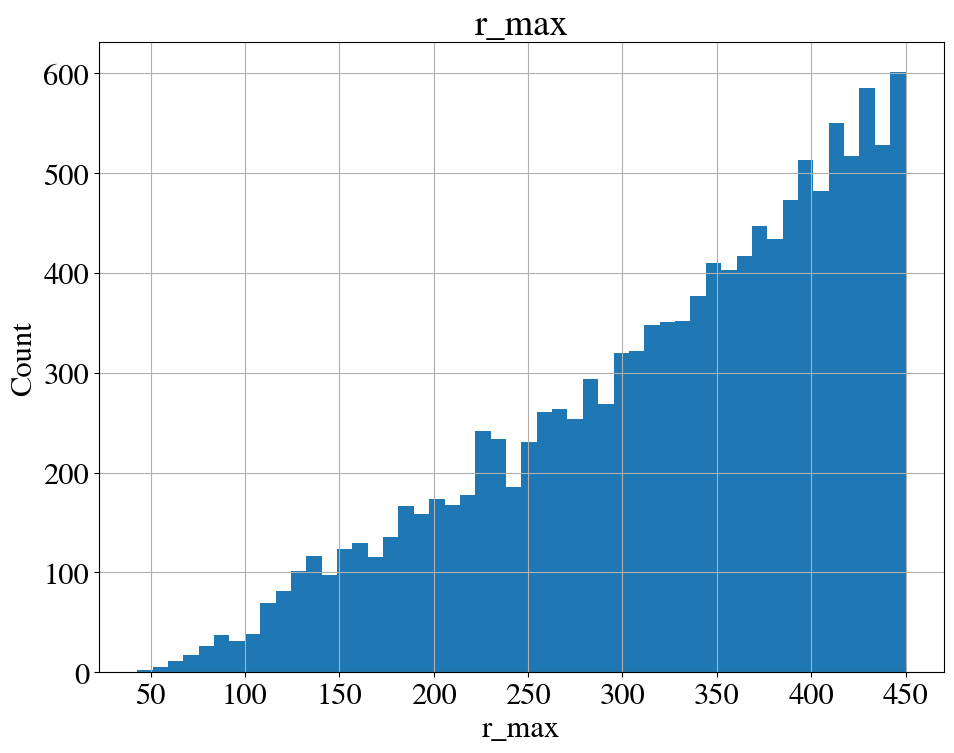

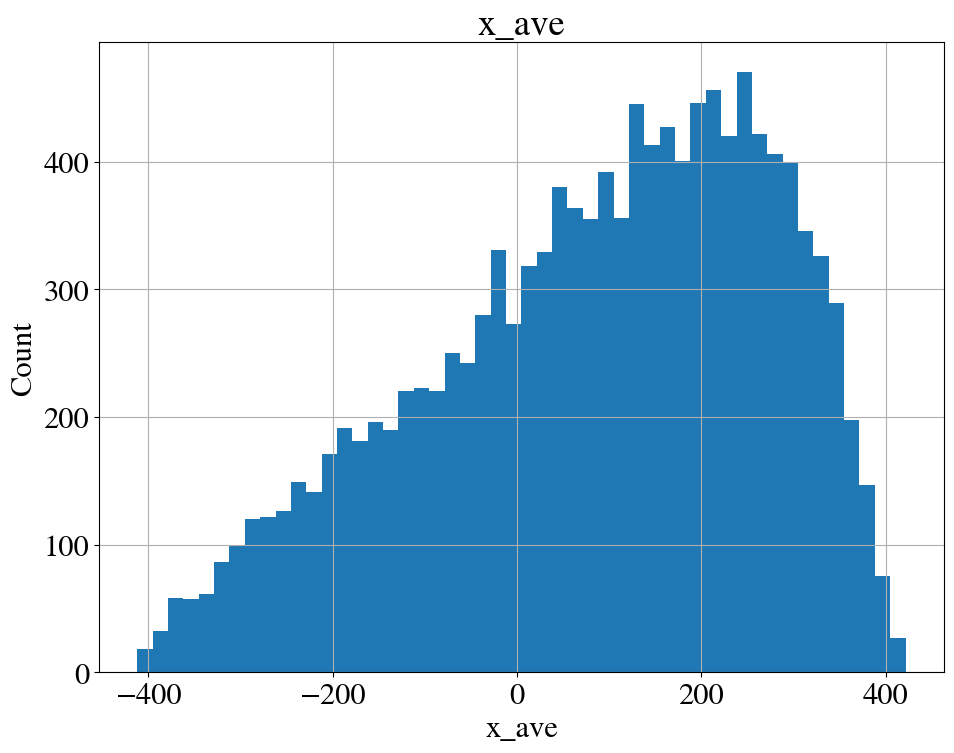

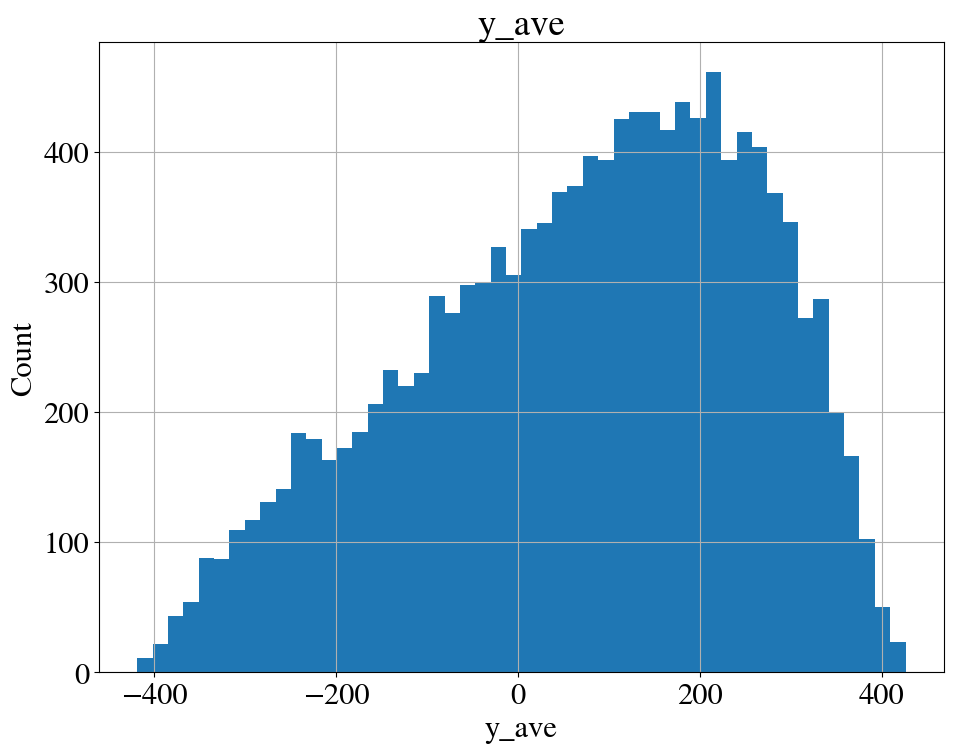

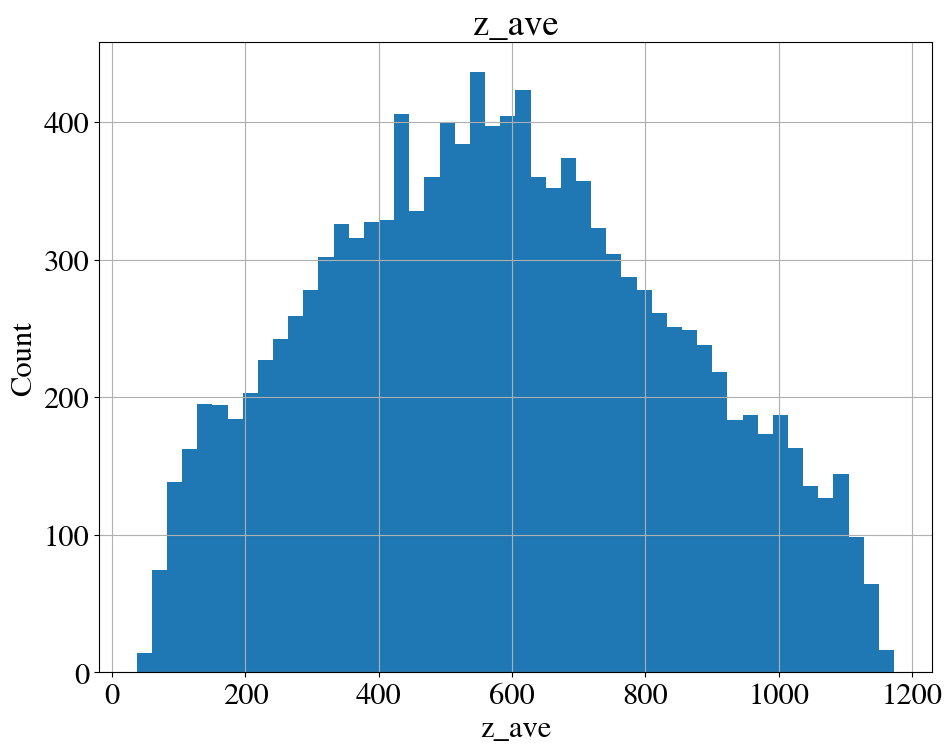

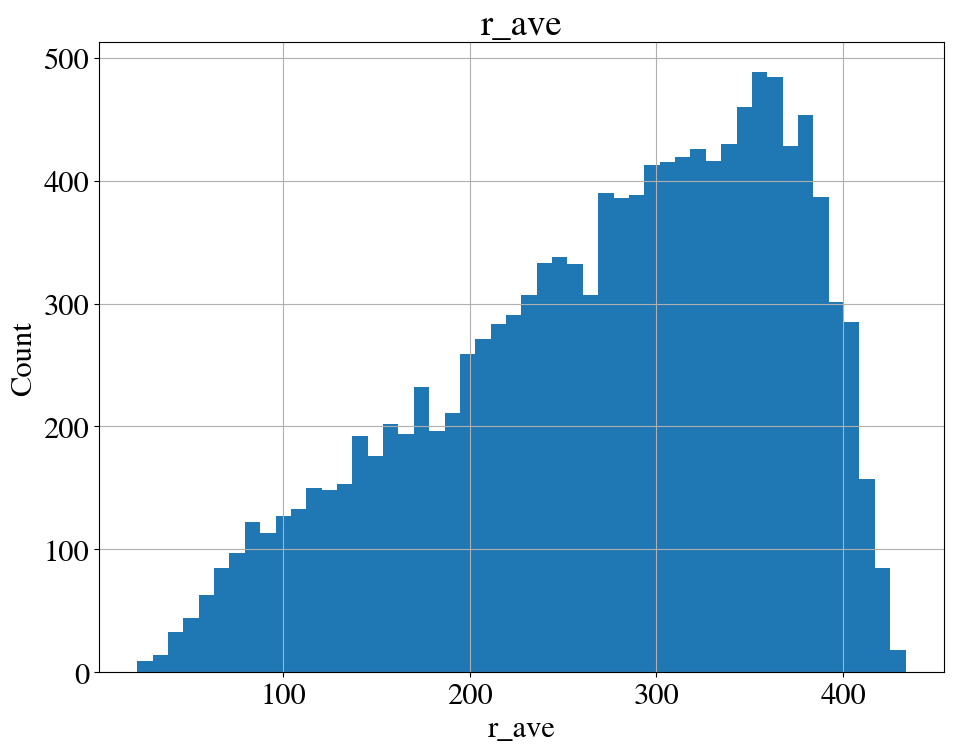

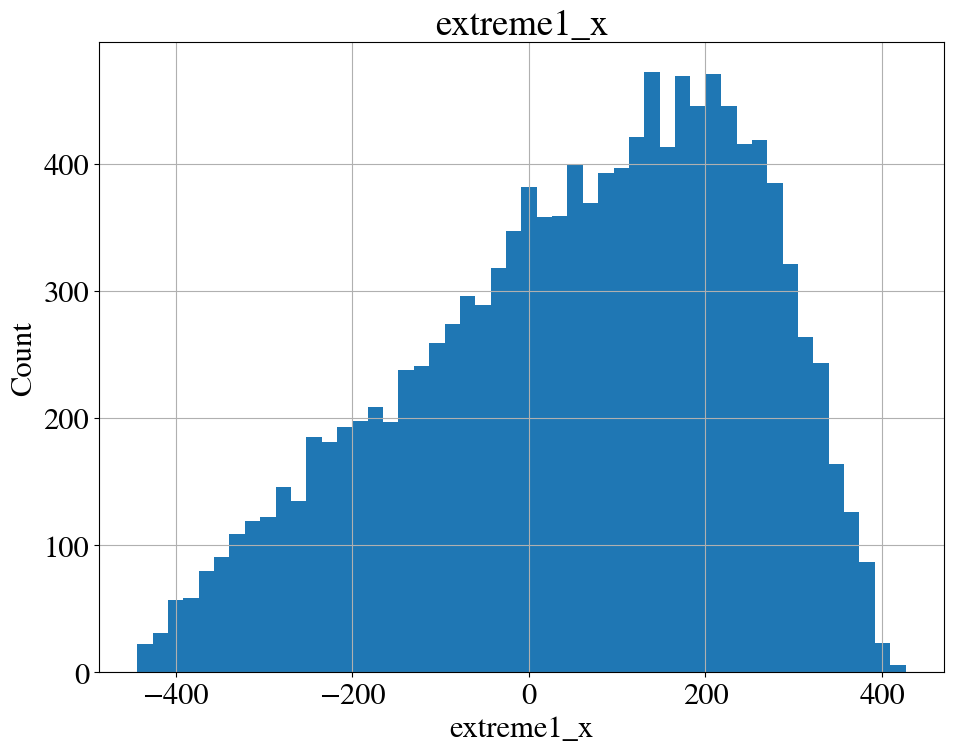

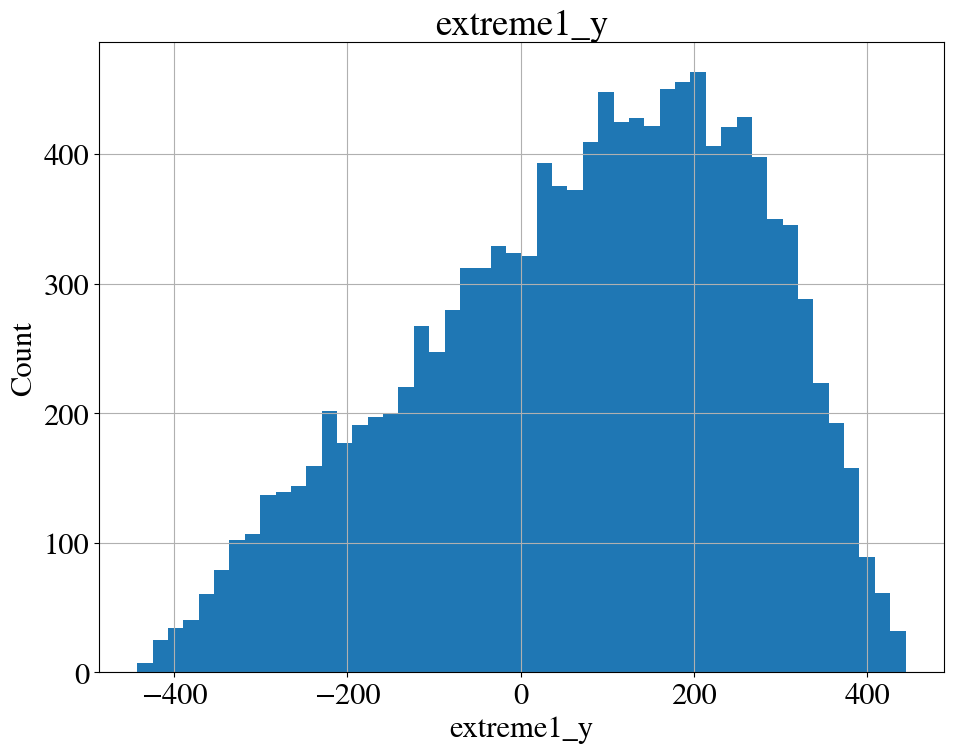

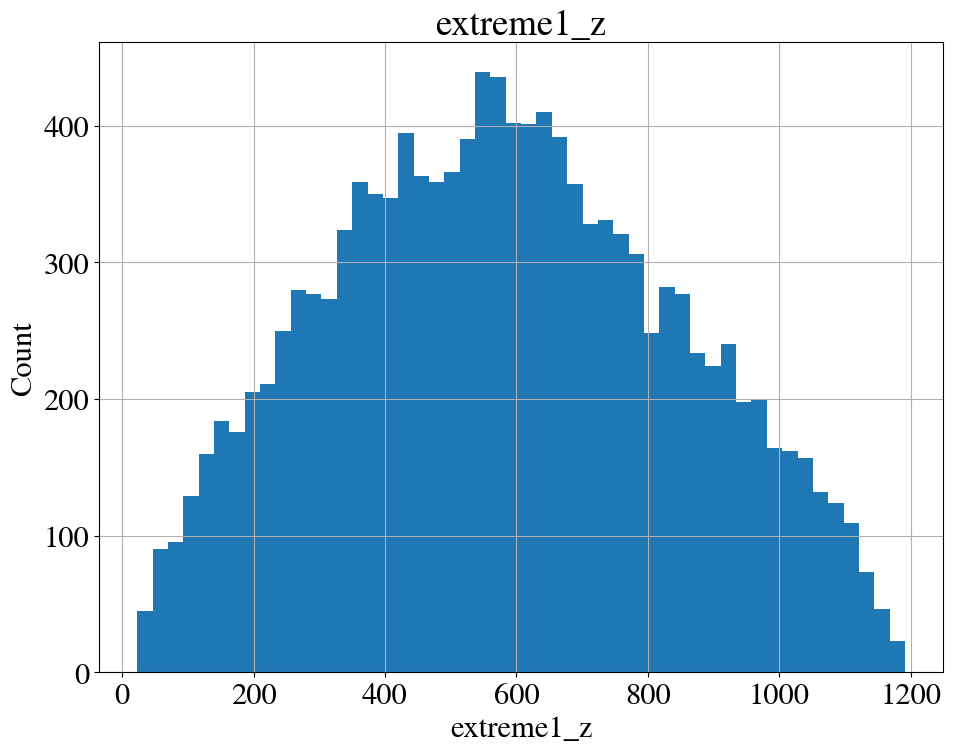

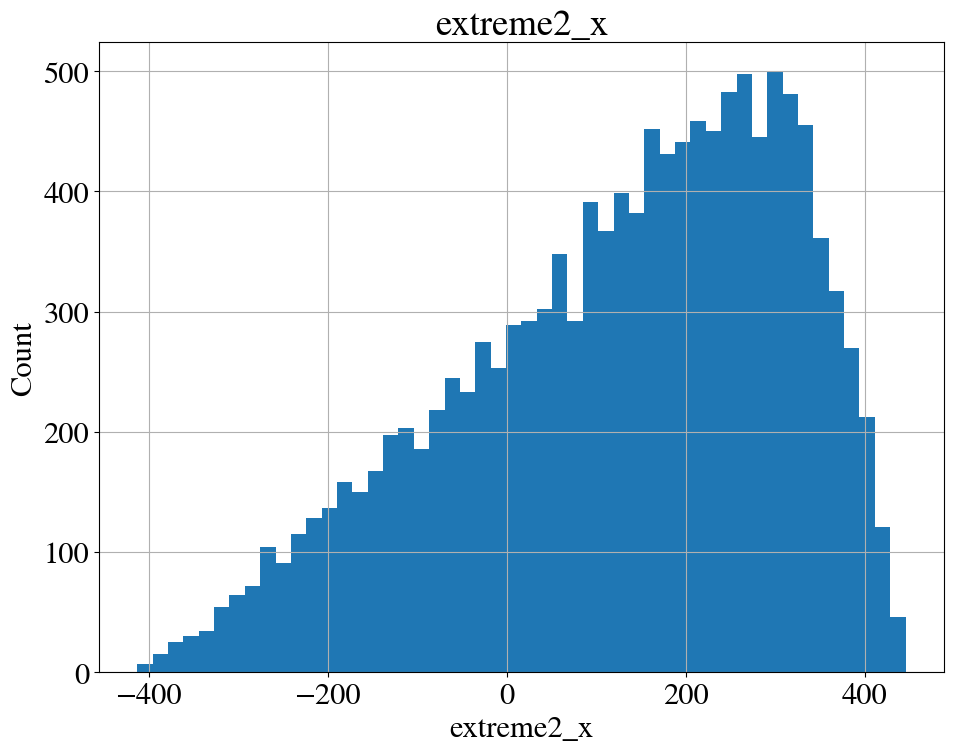

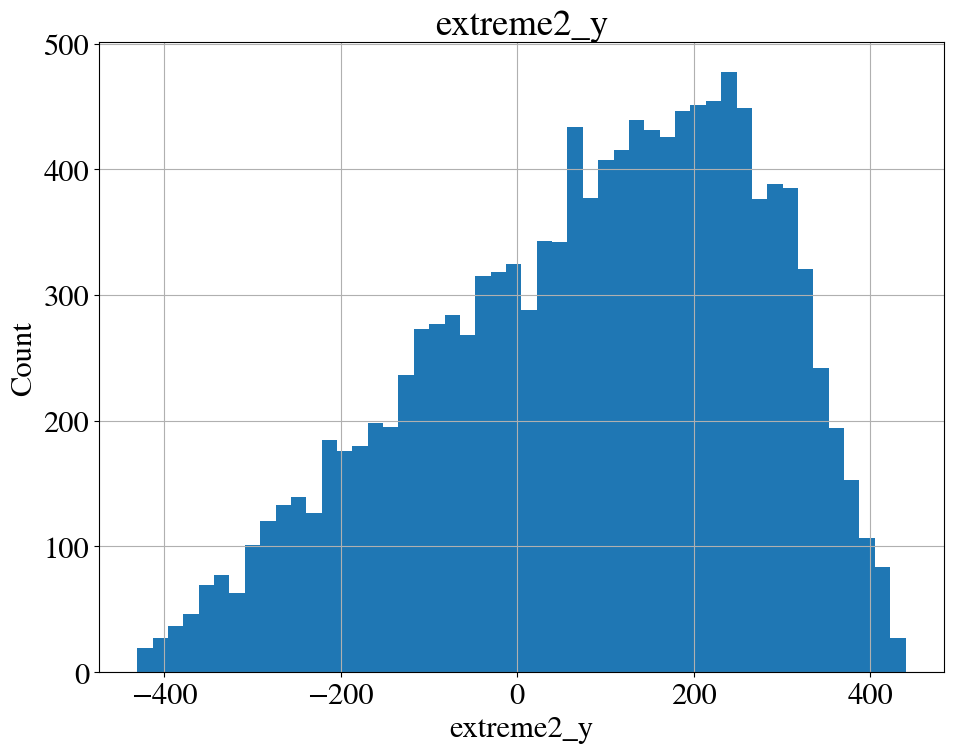

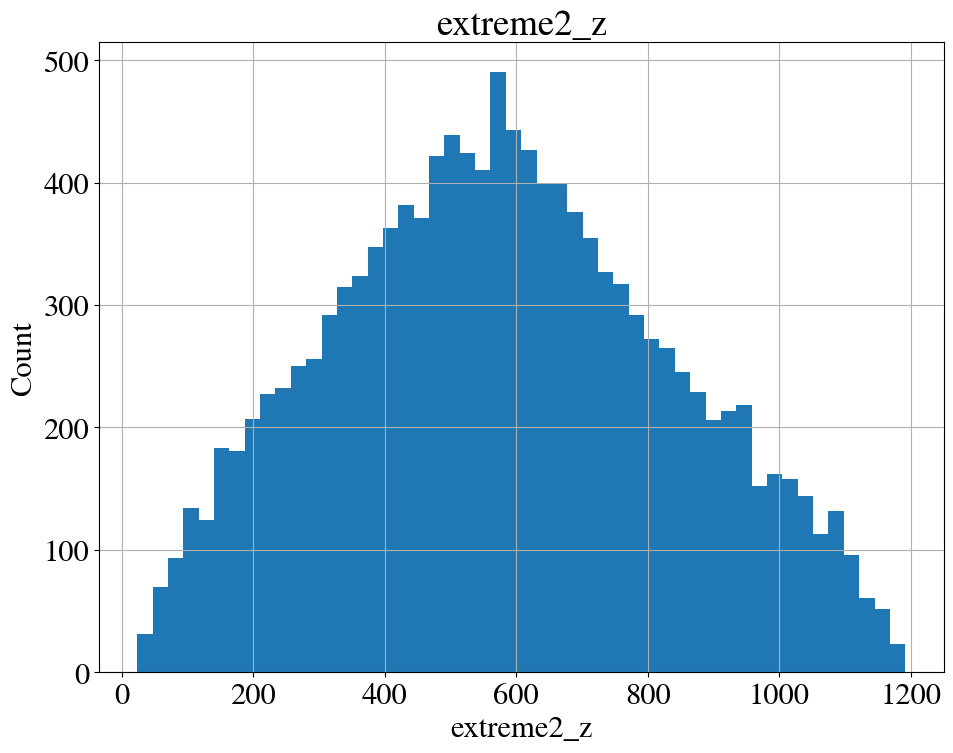

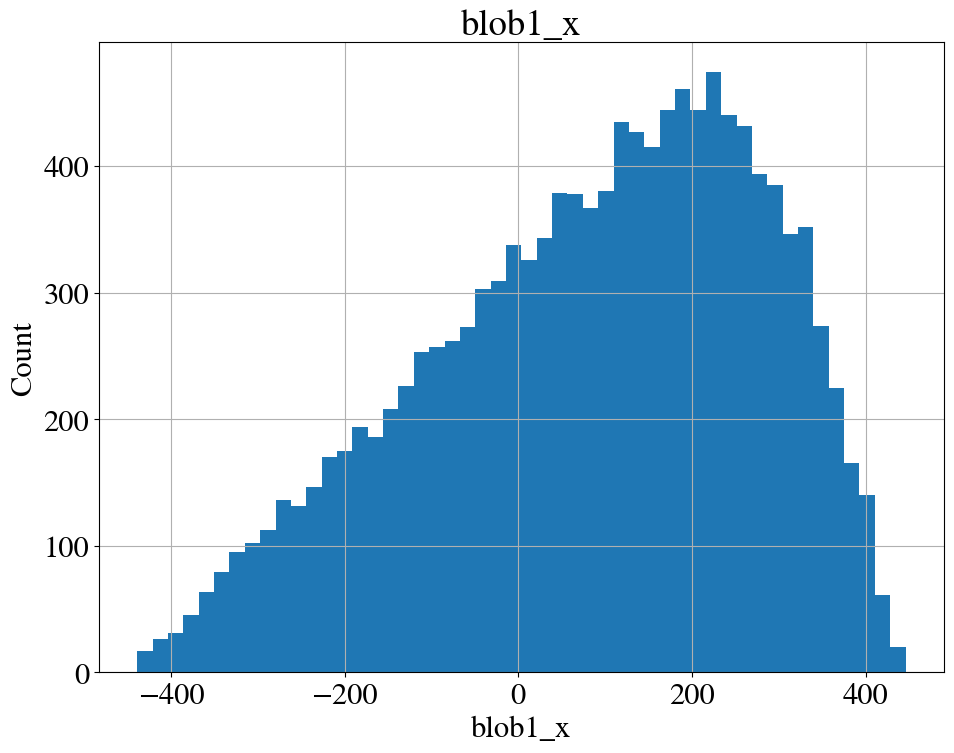

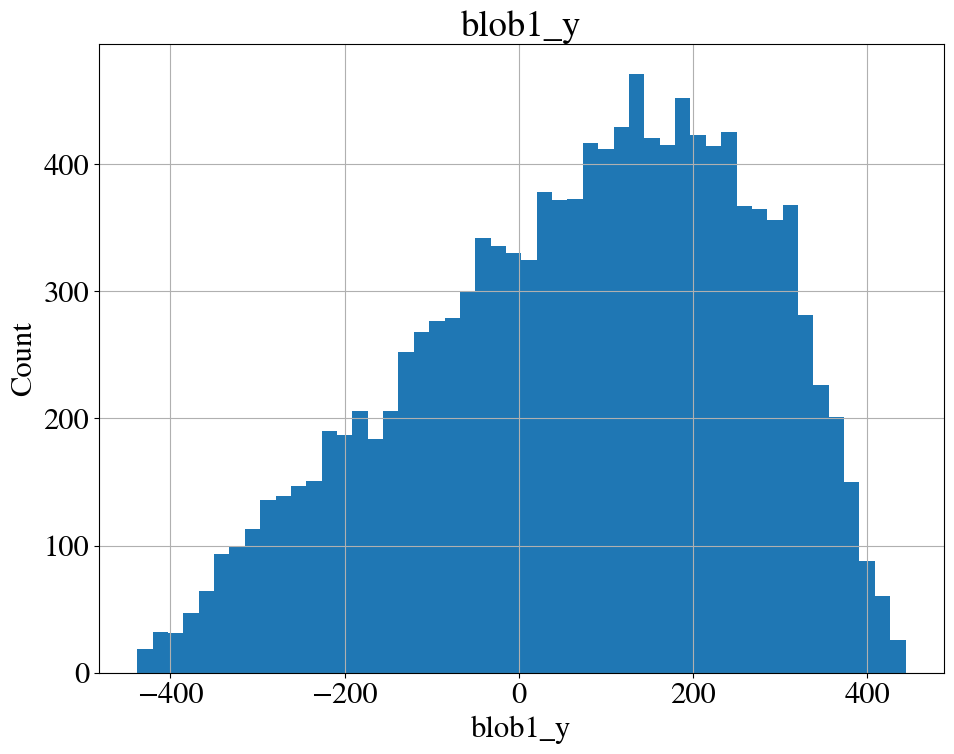

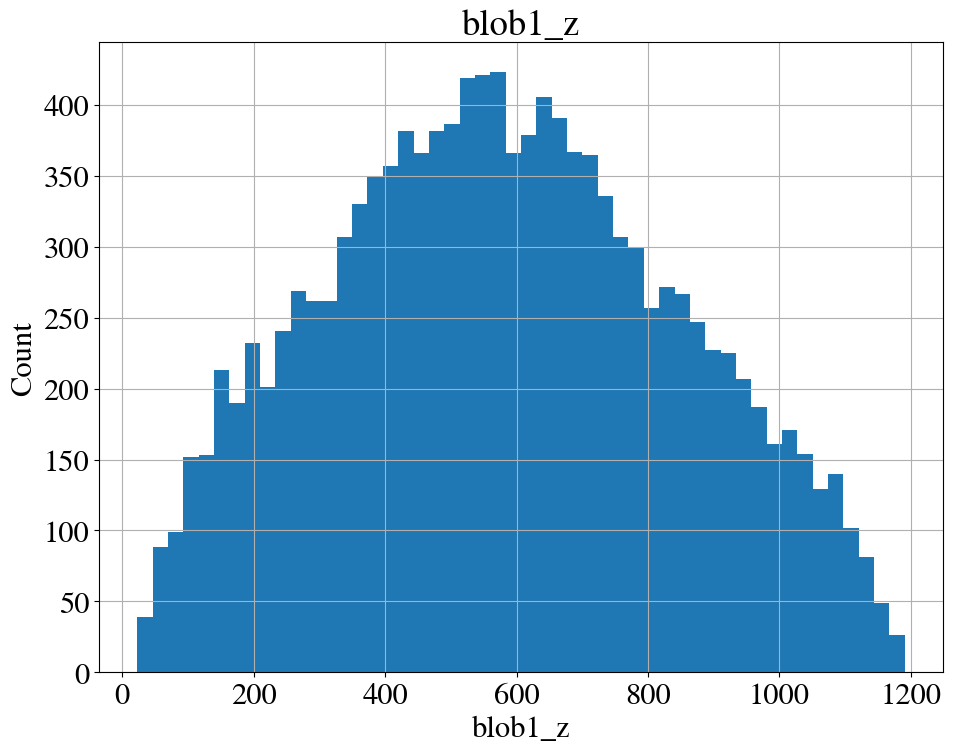

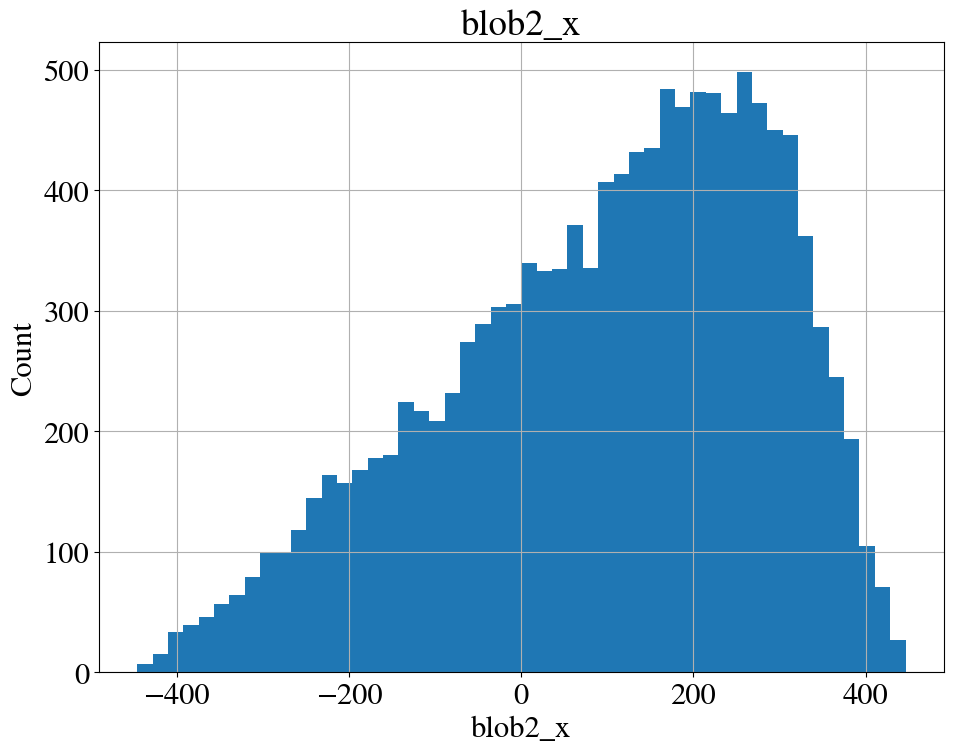

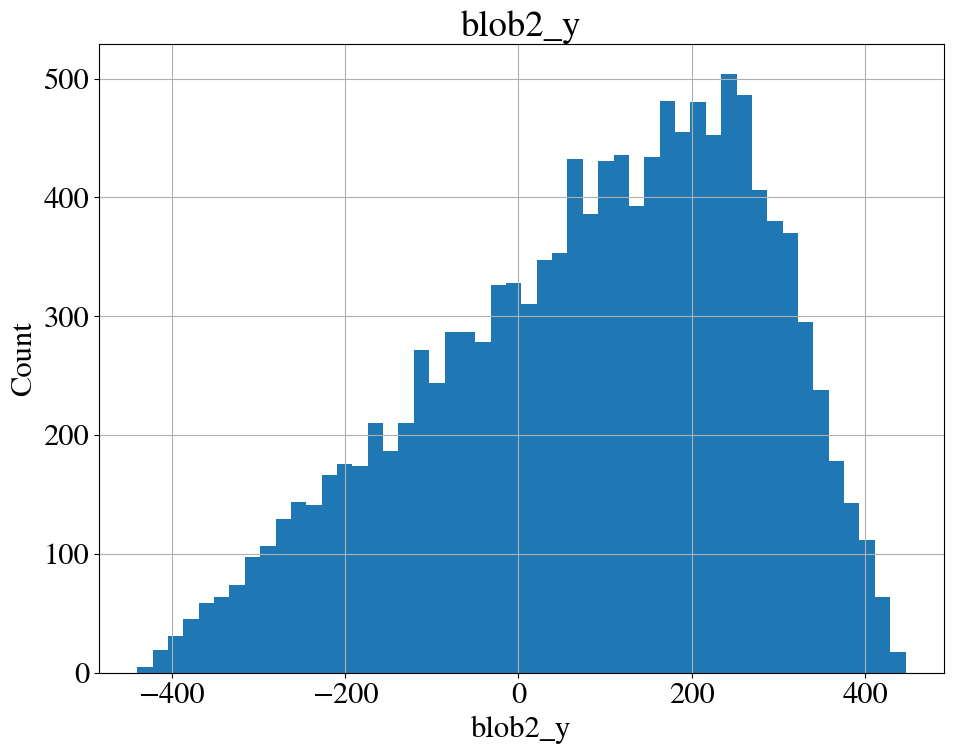

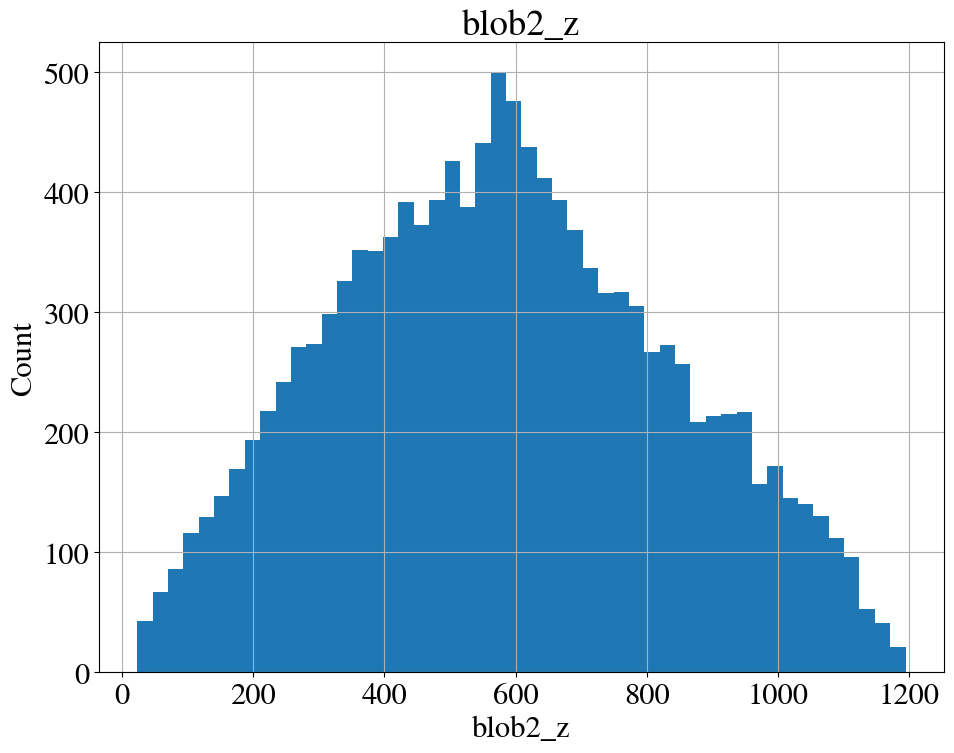

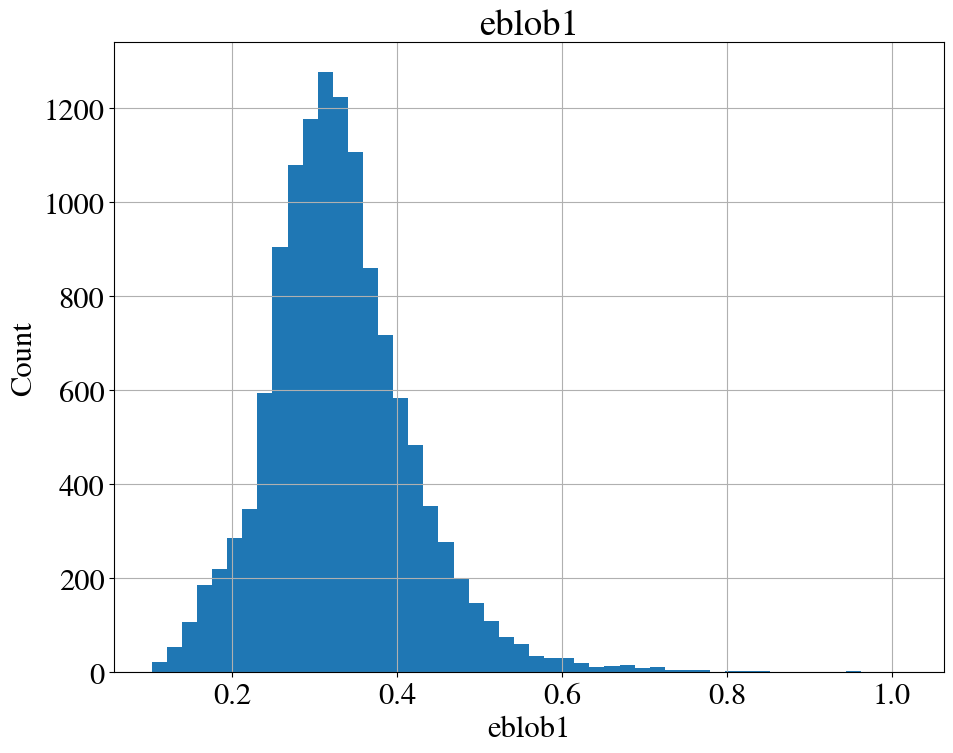

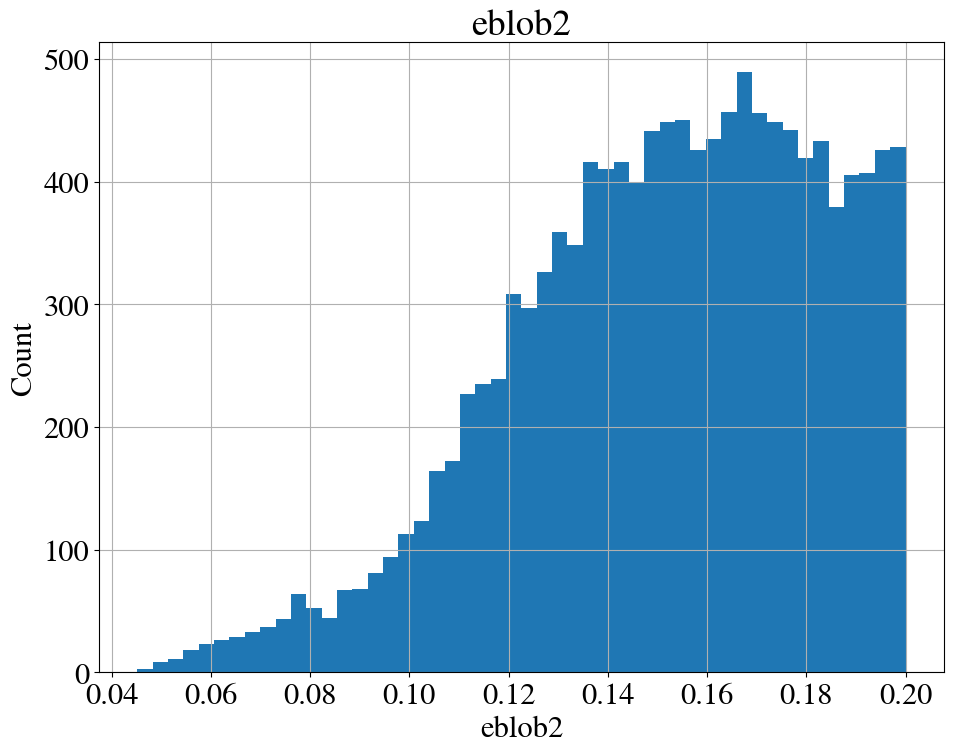

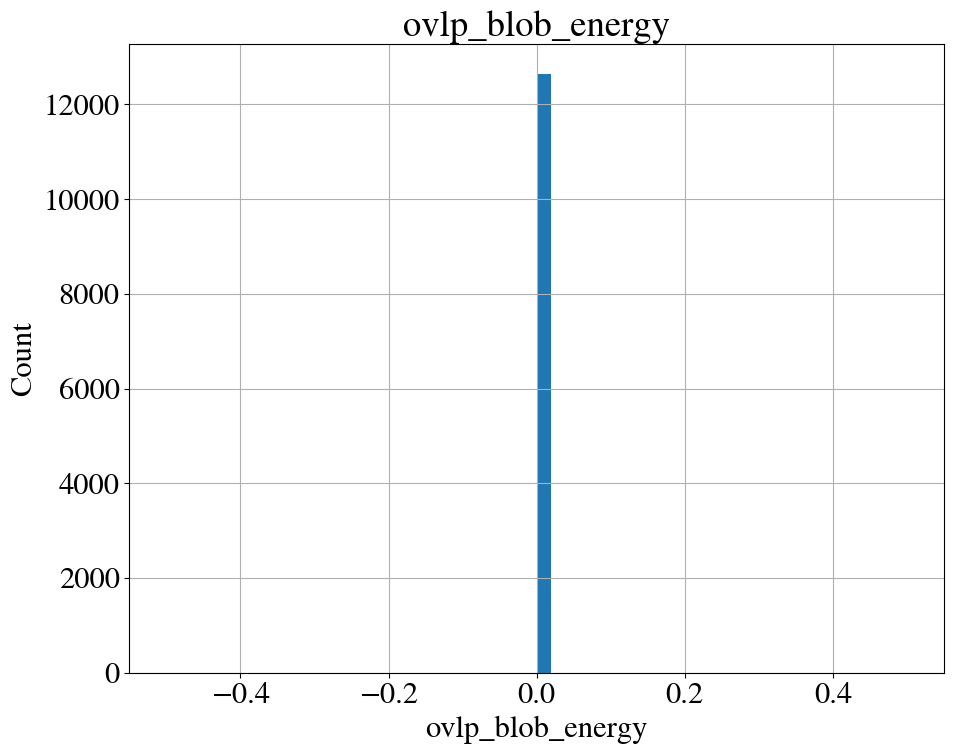

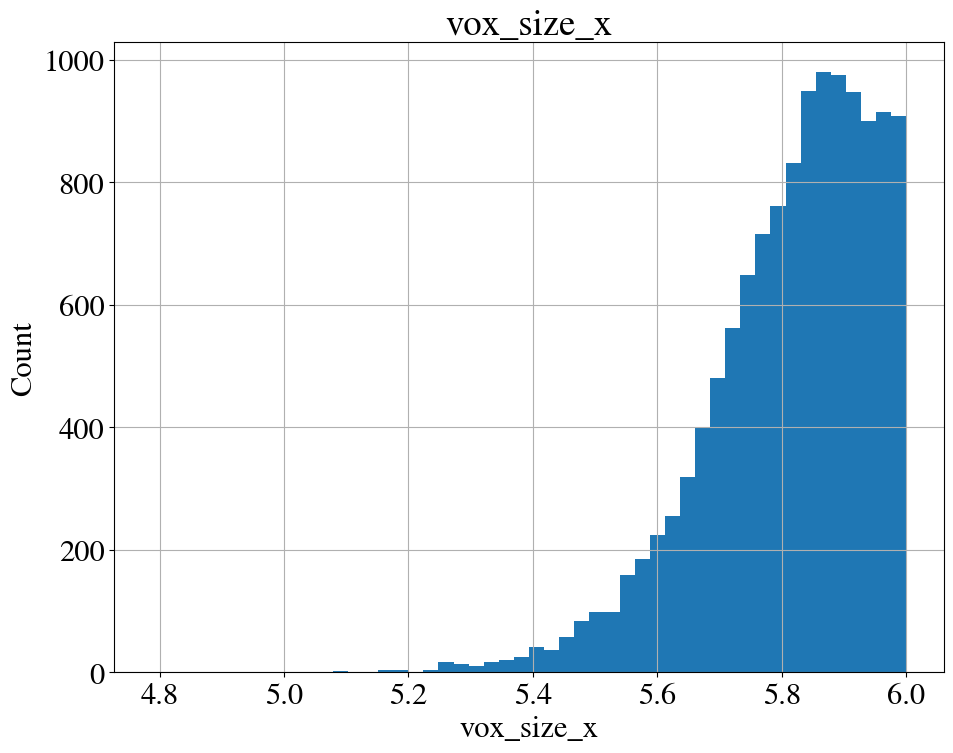

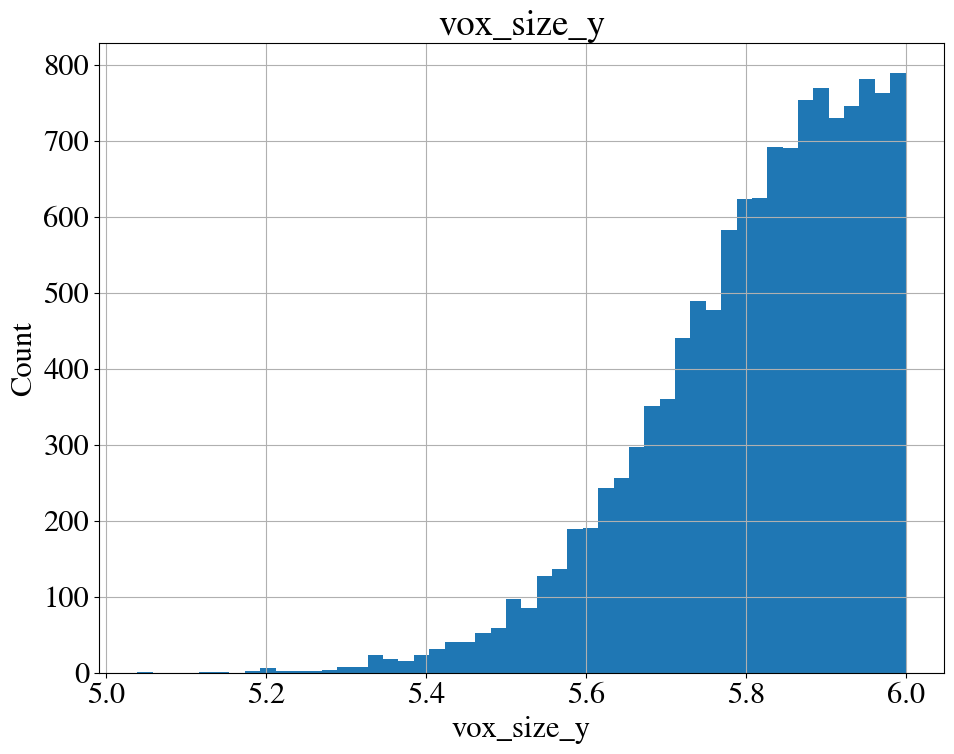

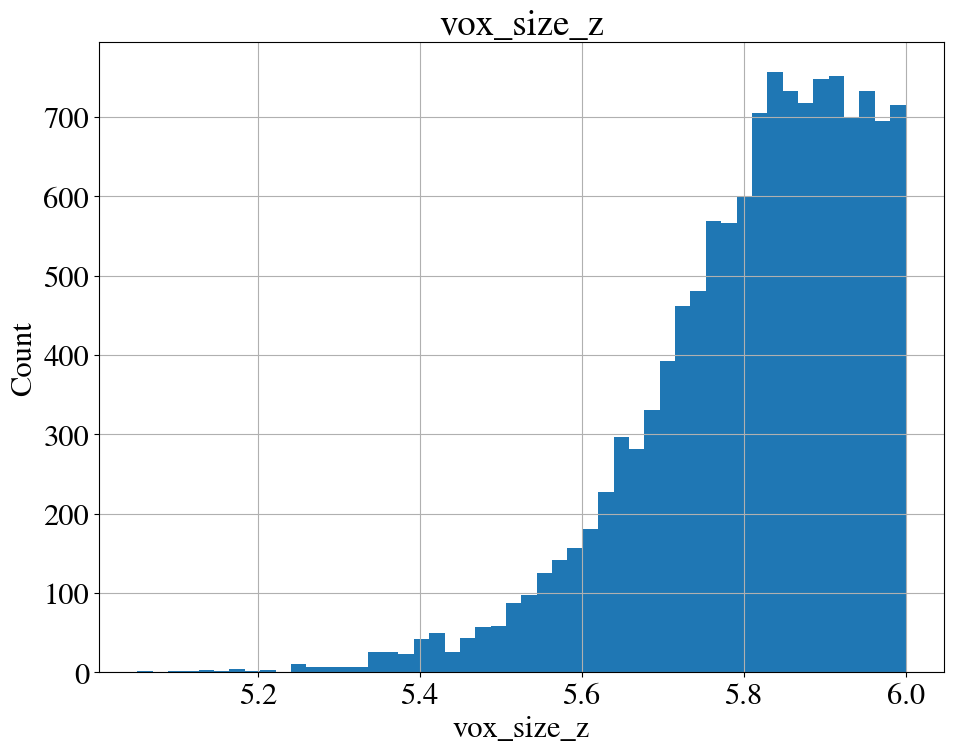

In [32]:
#funky_blob1s = signal_df[signal_df['eblob1'] < 0.2]
#funky_blob1s = funky_blob2s[funky_blob2s['eblob2'] < 0.2]
# Plot histograms for all columns in funky_blob2s
for col in funky_blob2s.columns:
    plt.figure()
    funky_blob2s[col].hist(bins=50)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Save event ids to a new file
np.save('MC_truth_FOM/FOM_funky_blobs_2s.npy', funky_blob2s['event'].values)



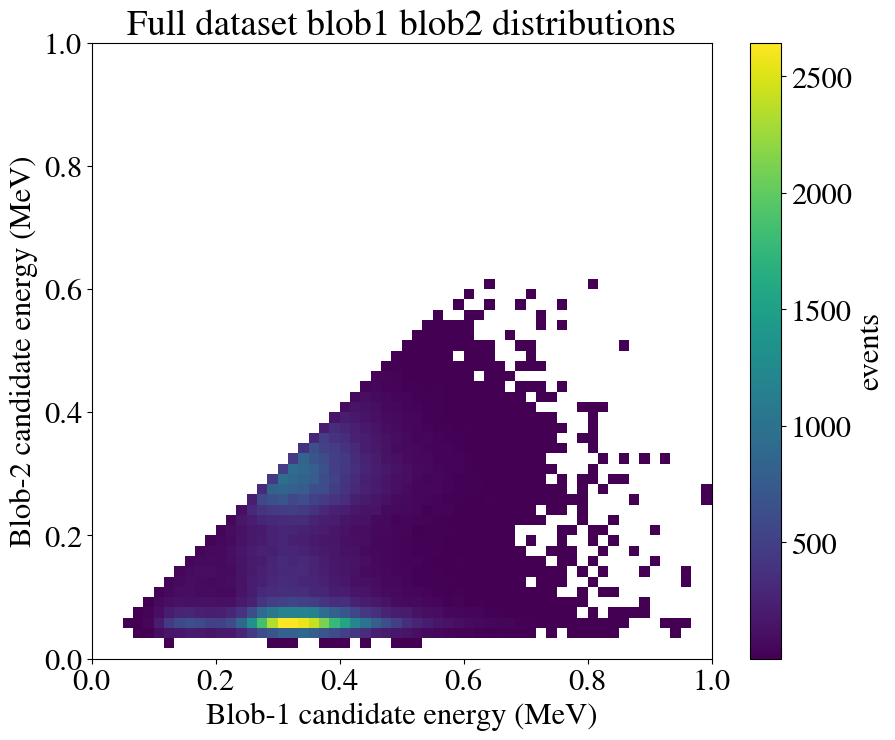

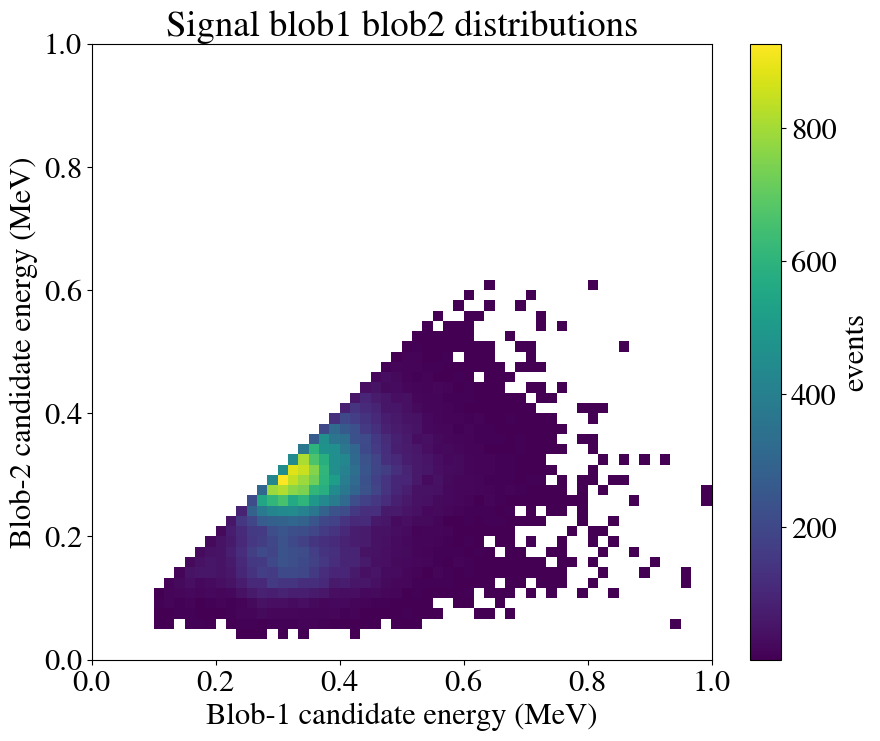

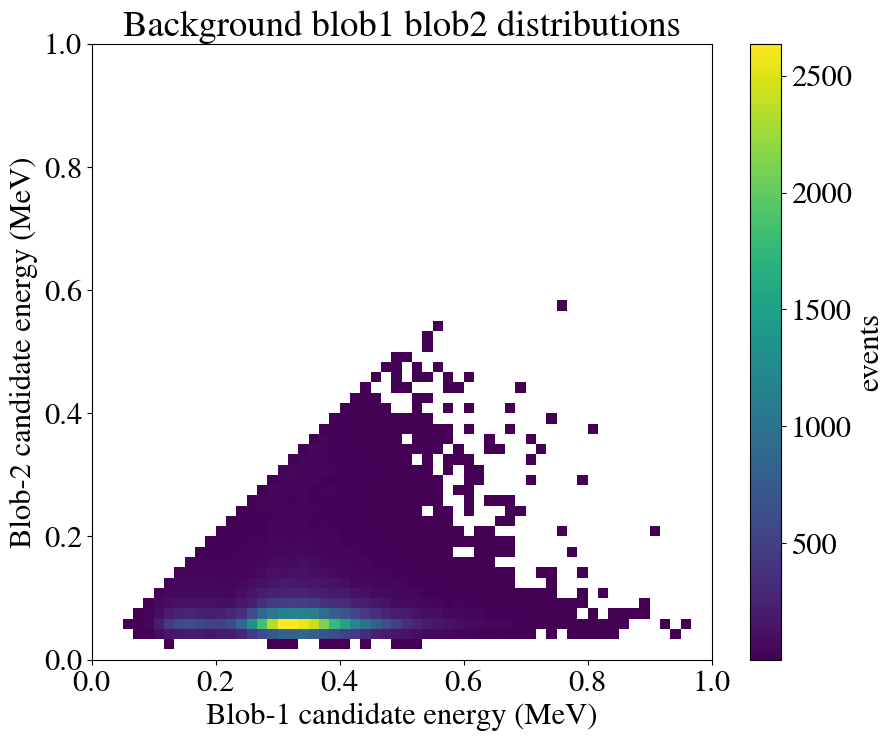

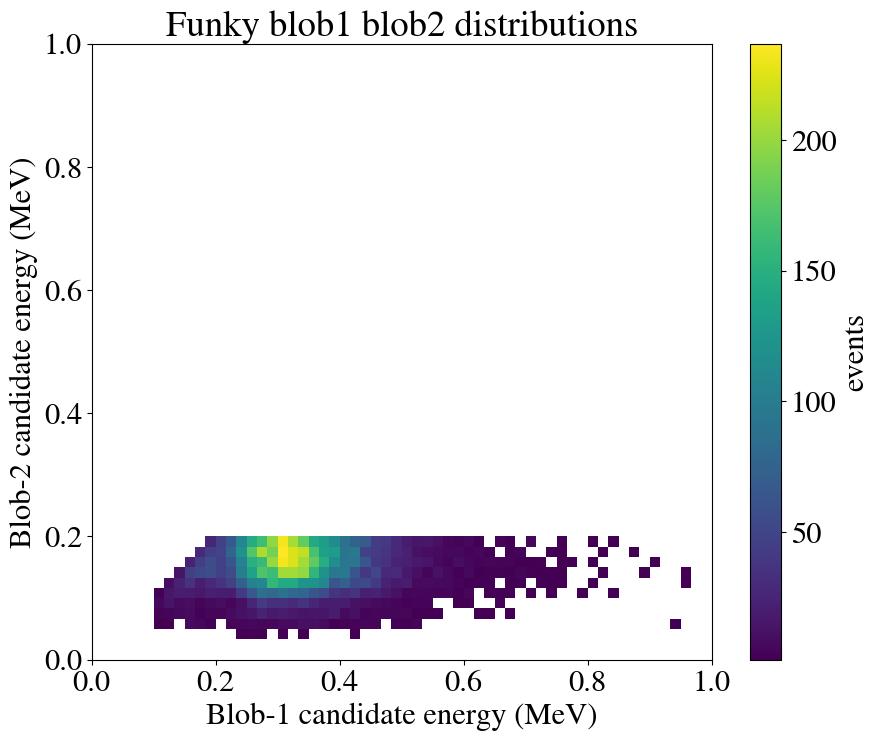

In [34]:
plt.hist2d(cut_hdst['eblob1'], cut_hdst['eblob2'], bins=(60, 60), range=((0, 1), (0, 1)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title('Full dataset blob1 blob2 distributions')
plt.show()


plt.hist2d(signal_df['eblob1'], signal_df['eblob2'], bins=(60, 60), range=((0, 1), (0, 1)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title('Signal blob1 blob2 distributions')
plt.show()


plt.hist2d(bckgnd_df['eblob1'], bckgnd_df['eblob2'], bins=(60, 60), range=((0, 1), (0, 1)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title('Background blob1 blob2 distributions')
plt.show()



plt.hist2d(funky_blob2s['eblob1'], funky_blob2s['eblob2'], bins=(60, 60), range=((0, 1), (0, 1)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title('Funky blob1 blob2 distributions')
plt.show()

In [49]:
cut_list = np.linspace(0, 0.6, 61)
q = FOM_func.true_fom_calc(signal_df, bckgnd_df, cut_list)

/scratch/halmazan/NEXT/testing/notebooks/FOM_creator/FOM_functions.py:873: RuntimeWarning: divide by zero encountered in double_scalars
  fom.append(e[i]/np.sqrt(b[i]))
/scratch/halmazan/NEXT/testing/notebooks/FOM_creator/FOM_functions.py:2000: RuntimeWarning: invalid value encountered in double_scalars
  f_error = f*np.sqrt((a_error/a)**2 +(b_error/b)**2)
/scratch/halmazan/NEXT/testing/notebooks/FOM_creator/FOM_functions.py:2020: RuntimeWarning: divide by zero encountered in double_scalars
  element_1 = np.square(a_error/np.sqrt(b))


In [50]:
print(q[0])
print(q[1])

[1.0, 1.0, 1.0, 1.000006766426346, 1.0041326569492115, 1.0782203821335814, 1.3123347658907965, 1.6296929193097278, 1.944592856268718, 2.2415628622878, 2.5159156958893716, 2.774549358945732, 3.02050456128827, 3.239367173822374, 3.436172626985586, 3.591247763762718, 3.7358285778929305, 3.8558535259765296, 3.953134569121763, 4.044345102612863, 4.131869830764371, 4.205174836872817, 4.253107920334523, 4.249728174141667, 4.19863948316147, 4.093358935722217, 3.9446981373667716, 3.7151716467519855, 3.4491747960114156, 3.201979995610572, 2.911833617462313, 2.6429491686855098, 2.410280178187448, 2.1535913236790343, 1.9155228782634663, 1.7400685558415867, 1.5216676884146692, 1.3238805867850545, 1.1530732510235597, 1.0660423688025362, 0.9230725604611475, 0.7960381698522468, 0.6118713355040916, 0.46454324664309415, 0.39054085805452887, 0.290860663834135, 0.25099349317727326, 0.20184437423166765, 0.18204901779073157, 0.15250124670627754, 0.12241138871902141, 0.10096321175543274, 0.07728385987293078,

Text(0.5, 1.0, 'True FOM')

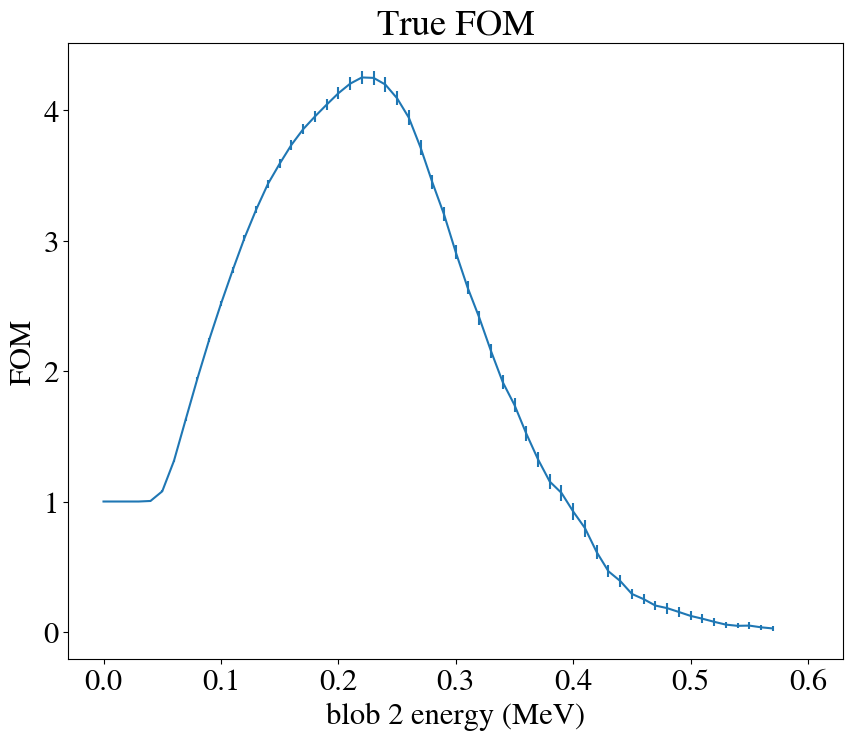

In [51]:
plt.errorbar(cut_list, q[0], yerr = q[1])
plt.xlabel('blob 2 energy (MeV)')
plt.ylabel('FOM')
plt.title('True FOM')

In [19]:
MC_456018 = [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357, 1.6788641891595388, 1.6922239267722416, 1.699861126709263, 1.6997686094402609, 1.6998303264675054, 1.698711717680303, 1.6927510828705188, 1.6739700151867287, 1.6410746313681333, 1.6042139687327037, 1.5628217415865937, 1.51133051165538, 1.457371396278447, 1.397631192621088, 1.3461898496522597, 1.2719406651196339, 1.2091244937926922, 1.11334159710724]
cl_456018 = np.linspace(0, 0.5, 51)

data_456018 = [1.0, 1.0, 0.999890941493442, 0.999819018500548, 0.9996276061401524, 0.9997467834907232, 0.9995058731992829, 0.9989033391407843, 0.9998090978056167, 1.0017678864888278, 1.0046837183945212, 1.0100737657039505, 1.0186305621868883, 1.0322130991367742, 1.0513772398057408, 1.081690677028547, 1.1180124645514646, 1.160688036473442, 1.2069706922658618, 1.2604136359065188, 1.3119109566621638, 1.3636718600771673, 1.412263534159618, 1.466991882686507, 1.5151936460603417, 1.5654663885273588, 1.6124525946304273, 1.6487039147113352, 1.6928819313133372, 1.7384962601026634, 1.778478734221356, 1.8128581329462452, 1.8450793385744853, 1.8633543186845432, 1.8763769415162062, 1.884191817870631, 1.9009559289758344, 1.8953273472214838, 1.8900346326849518, 1.8711289849822543, 1.8448178873369625, 1.7826457678128909, 1.757662265086213, 1.6977094064735911, 1.62306375807771, 1.5375570163131964, 1.4501092976191574, 1.3851209754954383, 1.3083062240464582, 1.2336313088356097, 1.1575626445836893]

Text(0, 0.5, 'FOM')

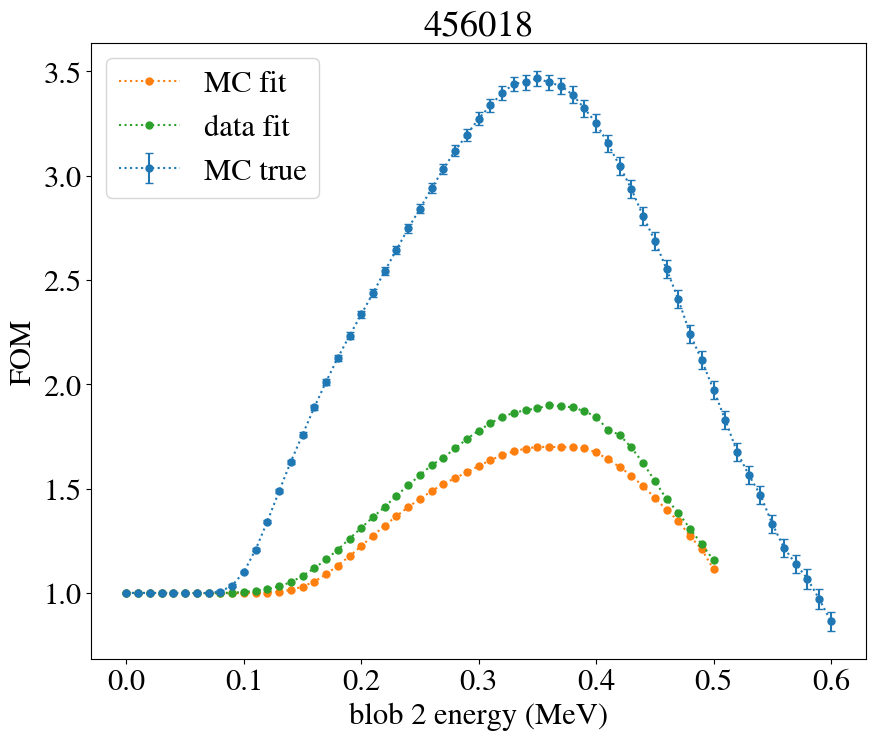

In [20]:
#plt.errorbar(cut_list, q[0], yerr = q[1], label = 'True')
plt.errorbar(cut_list, q[0], yerr=q[1], fmt='o', markersize=5, capsize=3, linestyle='dotted', label='MC true')
plt.plot(cl_456018, MC_456018, linestyle='dotted', marker='o', markersize=5, label='MC fit')
plt.plot(cl_456018, data_456018,linestyle='dotted', marker='o', markersize=5, label = 'data fit')
plt.xlabel('blob 2 energy (MeV)')
plt.title('456018')
plt.legend()
plt.ylabel('FOM')


In [24]:
np.save('MC_truth_FOM/FOM_MC_true', q)

/scicomp/builds/Rocky/8.7/Common/software/Anaconda3/2023.03-1/lib/python3.10/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [27]:
p = np.load('MC_truth_FOM/FOM_MC_true.npy', allow_pickle = True)
print(p)

[list([1.0, 1.0, 1.0000243614261215, 0.9998598829492009, 0.999672211738268, 0.9995885399125192, 0.999255755314394, 0.9985837109905996, 0.9982103505583713, 0.9979939319634334, 0.998206296846262, 0.9989102268741811, 1.0005250725345167, 1.0054542944491742, 1.0145514496255623, 1.0318119600402509, 1.0599145189504209, 1.100202880973846, 1.150670147494116, 1.205984558043687, 1.2683233663719637, 1.3334440251168889, 1.3993832320189574, 1.4642210991881732, 1.5285627958950472, 1.5916231558817402, 1.6510777114650212, 1.70844876898615, 1.760626494152227, 1.816495948023612, 1.8717689955553276, 1.9310521663145104, 1.9807427430567832, 2.0336671837936384, 2.077339599542128, 2.1123931038473964, 2.1358349637119294, 2.1636753852404467, 2.1833695805673727, 2.1972861920595914, 2.190464534296313, 2.1731987160032267, 2.1538244033181204, 2.1139714402561074, 2.0612482397646503, 1.999008533353197, 1.9265785406189724, 1.8583702660788084, 1.7598702931069627, 1.6661480495693008, 1.5459632760593434, 1.42639244429954

## separate out into the three sections

In [116]:

sig_sec_1 = signal_df[signal_df.z_ave < 250]
sig_sec_2 = signal_df[(signal_df.z_ave > 250) & (signal_df.z_ave <= 750)]
sig_sec_3 = signal_df[(signal_df.z_ave > 750) & (signal_df.z_ave <= 1500)]


bck_sec_1 = bckgnd_df[bckgnd_df.z_ave < 250]
bck_sec_2 = bckgnd_df[(bckgnd_df.z_ave > 250) & (bckgnd_df.z_ave <= 750)]
bck_sec_3 = bckgnd_df[(bckgnd_df.z_ave > 750) & (bckgnd_df.z_ave <= 1500)]



In [117]:
q_s1 = FOM_func.true_fom_calc(sig_sec_1, bck_sec_1, cut_list)
q_s2 = FOM_func.true_fom_calc(sig_sec_2, bck_sec_2, cut_list)
q_s3 = FOM_func.true_fom_calc(sig_sec_3, bck_sec_3, cut_list)

In [120]:
print(f'seg_1 FOM:\n{q_s1[0]}\nFOM error:\n{q_s1[1]}')
print(f'\n')
print(f'seg_2 FOM:\n{q_s2[0]}\nFOM error:\n{q_s2[1]}')
print(f'\n')
print(f'seg_3 FOM:\n{q_s3[0]}\nFOM error:\n{q_s3[1]}')

seg_1 FOM:
[1.0, 1.0, 1.0, 0.9996358166174811, 0.9995884822034042, 0.9994609995359013, 0.9996108300940629, 0.9981119393436604, 0.9979078205412445, 0.9976233644946978, 0.9972112015781657, 0.9965205577501492, 0.995910481883297, 0.9984399249458639, 1.003015845544626, 1.0169032941703053, 1.0404676991124158, 1.0799994903061774, 1.1344178282971078, 1.188559186821133, 1.2468633851219344, 1.3105493288105463, 1.3754713321130743, 1.4498522593987935, 1.5235648432443811, 1.5811332119637034, 1.638307899709094, 1.6994355583921825, 1.7390169854326167, 1.7908276975218882, 1.833865177683637, 1.8864713807404438, 1.934085701213247, 1.9832270810909212, 2.0455091873469824, 2.0893456934766057, 2.1307061190414887, 2.174242264885191, 2.207185103809422, 2.2532523893067347, 2.273531309572014, 2.285895519905396, 2.298010948013342, 2.302769014401779, 2.3122209351655805, 2.259813353892436, 2.186881972215845, 2.1171160247905445, 2.0340707530157327, 1.9756469579624552, 1.9081113220833872, 1.8144478274846234, 1.71685